In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import display
import numpy as np
import os
import torch
from PIL import Image, ImageDraw
from plotly.subplots import make_subplots

# SOMMAIRE

##### [Introduction](#dim)

##### I -  [Enveloppe](#Experiments)  
##### II -  [Time](#Time)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - [Methods comparaison](#Methodes)   
##### III -  [Global analysis IoU](#Complexity)

## Envelope

In [108]:
folder_path = "/Users/ncohmpli/Documents/Professionnel/Technical/Verification/Lirpa for IoU/manip/pipeline/lirpa_iou_pipeline/results/many_methods/"

In [109]:
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

In [110]:
dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, converters={"bounds_clip":pd.eval,  'IoU_vanilla':pd.eval,'IoU_extension':pd.eval,'IoU_extension_greedy':pd.eval})
    dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)

In [111]:
combined_df = combined_df[combined_df["perturbation"] != "contrast"]

In [112]:
folder_mnist_contrast = "/Users/ncohmpli/Documents/Professionnel/Technical/Verification/Lirpa for IoU/manip/pipeline/lirpa_iou_pipeline/urgent_new_results/MNIST_CROWN_contrast/" 

In [113]:
csv_files_mnist_contrast = [file for file in os.listdir(folder_mnist_contrast) if file.endswith('.csv')]

In [114]:
dfs = []
for file in csv_files_mnist_contrast:
    file_path = os.path.join(folder_mnist_contrast, file)
    df = pd.read_csv(file_path, converters={"bounds_clip":pd.eval,  'IoU_vanilla':pd.eval,'IoU_extension':pd.eval,'IoU_extension_greedy':pd.eval})
    dfs.append(df)
    mnist_contrast = pd.concat(dfs, ignore_index=True)

In [115]:
combined_df = combined_df.drop(columns="eps_contrast")

In [119]:
combined_df =  pd.concat([combined_df, mnist_contrast])
#np.unique(new_df.groupby(["perturbation", "image_id"]).agg("count")["method"])

In [121]:
combined_df = combined_df.sort_values(by="image_id")

In [122]:
combined_df["lb_box"] = combined_df["bounds_clip"].apply(lambda x: x[0])
combined_df["lb_box0"] = combined_df["bounds_clip"].apply(lambda x: x[0][0])
combined_df["ub_box"] = combined_df["bounds_clip"].apply(lambda x: x[1])

In [123]:
combined_df["IoU_vanilla_delta"] = combined_df.IoU_vanilla.apply(lambda x: x[1]-x[0])
combined_df["IoU_extension_delta"] = combined_df.IoU_extension.apply(lambda x: x[1]-x[0])

combined_df["Vanilla_upper"] = combined_df.IoU_vanilla.apply(lambda x: x[1])
combined_df["Vanilla_lower"] = combined_df.IoU_vanilla.apply(lambda x: x[0])
combined_df["Extension_upper"] = combined_df.IoU_extension.apply(lambda x: x[1])
combined_df["Extension_lower"] = combined_df.IoU_extension.apply(lambda x: x[0])

In [124]:
eps0 = combined_df[combined_df["eps"]==0]
bad_images_extension = np.unique(eps0[eps0["IoU_extension_delta"]>0.0001]["image_id"])
bad_images_vanilla = np.unique(eps0[eps0["IoU_vanilla_delta"]>0.0001]["image_id"])
def bad_images(im):
    if (im in bad_images_extension) or (im in bad_images_vanilla):
        return(True)
    return(False)
combined_df["bad_images"] = combined_df["image_id"].apply(lambda x: bad_images(x))
combined_df = combined_df[combined_df["bad_images"] == False]

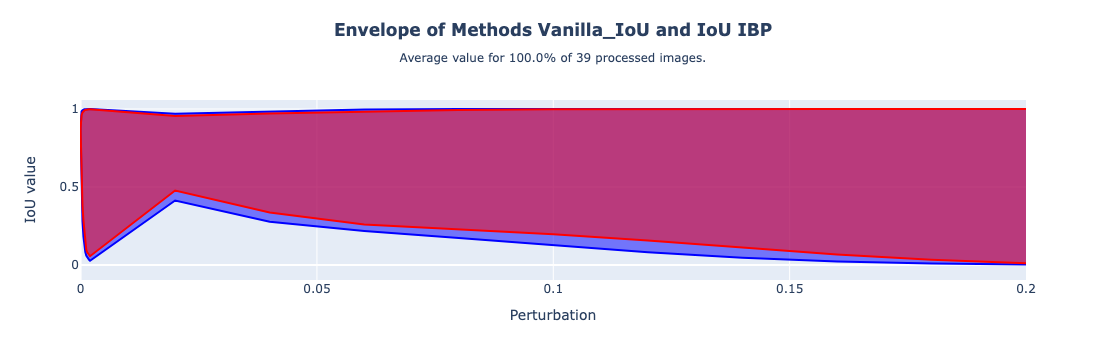

In [125]:
def envelop_graph(df_grouped, eps="eps", title='Envelope of Methods Vanilla_IoU and IoU IBP', 
                  subtitle=None, subsubtitle="", annotations=""):
    """df should have the columns
    "Eps" "Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"
    """

    trace_A = go.Scatter(
        x=df_grouped[eps],
        y=df_grouped["Vanilla_upper"],
        fill=None,
        mode='lines',
        line=dict(color='blue'),
        name='Vanilla_IoU Upper Bound', 
        showlegend=False
    )
    trace_A_lower = go.Scatter(
        x=df_grouped[eps],
        y=df_grouped["Vanilla_lower"],
        fill='tonexty',  # Espace remplissage ! 
        mode='lines',
        line=dict(color='blue'),
        name='Vanilla_IoU Lower Bound',
        showlegend=False
    )
    trace_B = go.Scatter(
        x=df_grouped[eps],
        y=df_grouped["Extension_upper"],
        fill=None,
        mode='lines',
        line=dict(color='red'),
        name='IoU_extension Upper Bound',
        showlegend=False
    )
    trace_B_lower = go.Scatter(
        x=df_grouped[eps],
        y=df_grouped["Extension_lower"],
        fill='tonexty',  # Espace remplissage ! 
        mode='lines',
        line=dict(color='red'),
        name='IoU_extension Lower Bound',
        showlegend=False
    )
    
    layout = go.Layout(
        title=title,
        xaxis=dict(title='Perturbation'),
        yaxis=dict(title='IoU value')
    )
    
    fig = go.Figure(layout=layout)
    fig.add_trace(trace_A)
    fig.add_trace(trace_A_lower)
    fig.add_trace(trace_B)
    fig.add_trace(trace_B_lower)

    decalou = (df_grouped["Extension_upper"].max()-df_grouped["Extension_upper"].min())/1.5
    x_vanilla, x_optimal = df_grouped[eps].describe()["25%"]/10, df_grouped[eps].describe()["25%"]/10
    y_vanilla, y_optimal = df_grouped["Vanilla_lower"].min()-decalou, df_grouped["Vanilla_lower"].min()
    decalage = df_grouped[eps].describe()["25%"]/5

    """
    fig.add_trace(go.Scatter(
    x=[x_vanilla,x_optimal],
    y=[y_vanilla, y_optimal],
    mode='markers',
    marker=dict(color=['blue', 'red'], size=[10, 10]),  # Ajustez la taille au besoin
    showlegend=False,
    hoverinfo='none'))
    """

    annotations = [
    dict(x=x_vanilla+decalage, y=y_vanilla, xref="x", yref="y",
         text=annotations, showarrow=False)]

    

    fig.update_layout(annotations=annotations)
    

    if subtitle != None:
        fig.update_layout(
            title={'text': f'<b>{title}</b><br><sub>{subtitle}</sub><br><sub><i>{subsubtitle}</i></sub>',
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'}
            )


    return(fig)

df_grouped = combined_df.groupby(["eps"])[["Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"]].agg("mean")
df_grouped = df_grouped.reset_index()

def percentage_value(df_plotted, df=df):
    """Percentage images processed on this plot
    """
    plotted = len(np.unique(list(df_plotted["image_id"])))
    globaldf = len(np.unique(list(df["image_id"])))
    return((plotted/globaldf)*100)
nb_im_proc = combined_df.groupby("image_id")[["eps"]].agg("count").shape[0]
envelop_graph(df_grouped, eps="eps", title=f'Envelope of Methods Vanilla_IoU and IoU IBP', subtitle=f"Average value for {percentage_value(df)}% of {nb_im_proc} processed images.")

In [91]:
df_grouped

eps  eps_contrast  Vanilla_upper  Vanilla_lower  Extension_upper  \
0   0.0000         0.000       0.887069       0.887069         0.887069   
1   0.0002         0.001       0.998718       0.599041         0.964336   
2   0.0004         0.002       1.000000       0.362310         0.988016   
3   0.0006         0.003       1.000000       0.196455         0.999097   
4   0.0008         0.004       1.000000       0.094355         1.000000   
5   0.0010         0.005       1.000000       0.038282         1.000000   
6   0.0012         0.006       1.000000       0.009316         1.000000   
7   0.0014         0.007       1.000000       0.001555         1.000000   
8   0.0016         0.008       1.000000       0.000024         1.000000   
9   0.0018         0.009       1.000000       0.000000         1.000000   
10  0.0020         0.010       1.000000       0.000000         1.000000   

    Extension_lower  
0          0.887069  
1          0.717465  
2          0.539024  
3          0.379030  
4          0.245889  
5          0.134040  
6          0.041507  
7          0.008612  
8          0.000161  
9          0.000000  
10         0.000000

In [126]:
dico_pert={}
for perturbation_i in np.unique(combined_df["perturbation"]):
    dico_pert[perturbation_i] = combined_df[combined_df["perturbation"] == perturbation_i]

In [131]:
eps_pert_dict = {'brightness':"eps", 'contrast':"eps", 'whitenoise':"eps"}

In [132]:
pretty_names = {'brightness':'Brightness', 'contrast':'Contrast', 'whitenoise':'Whitenoise'}

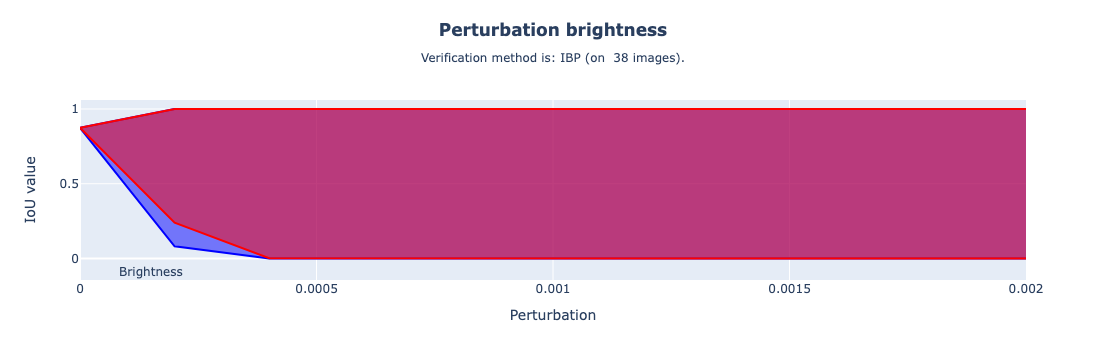

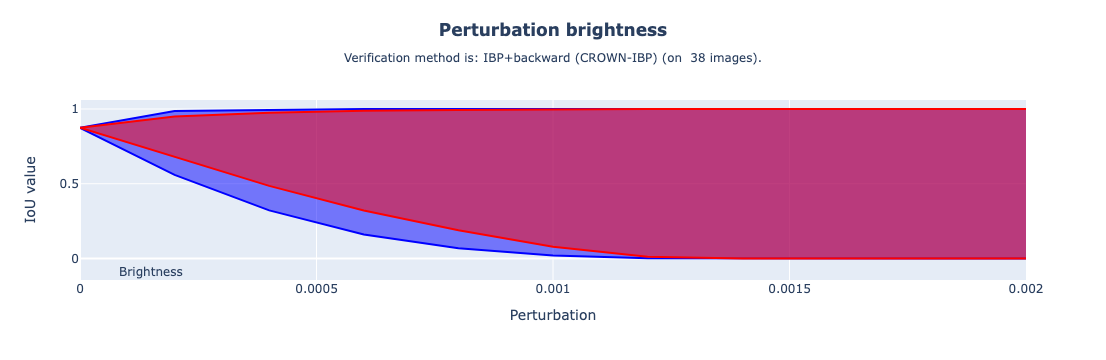

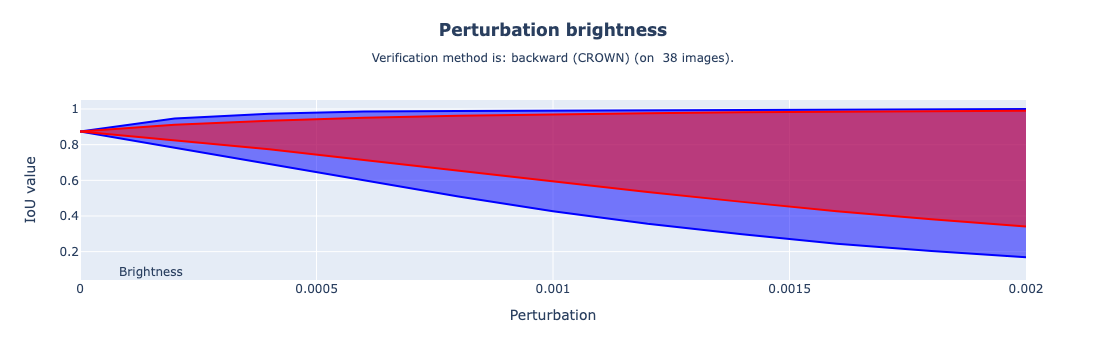

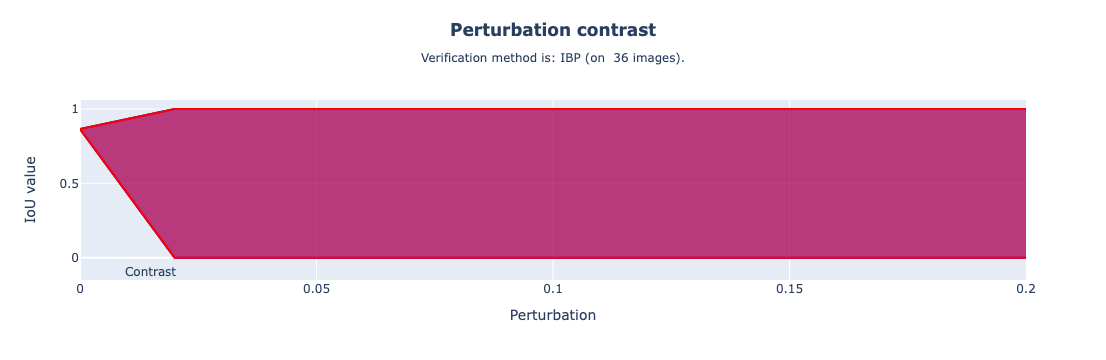

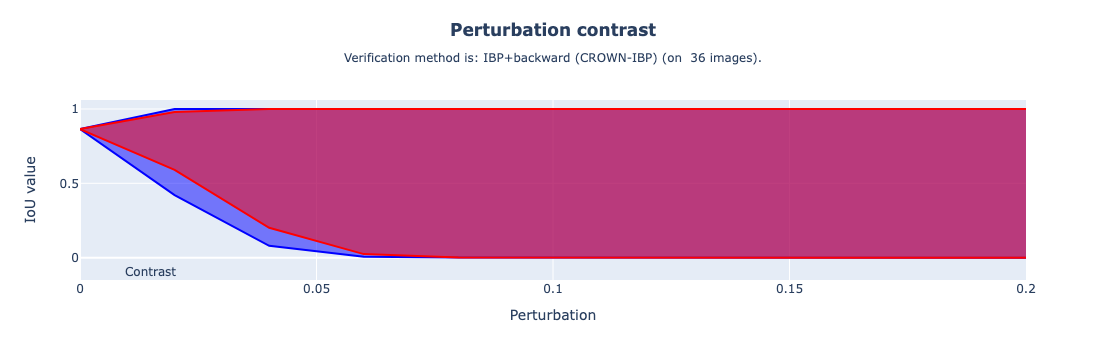

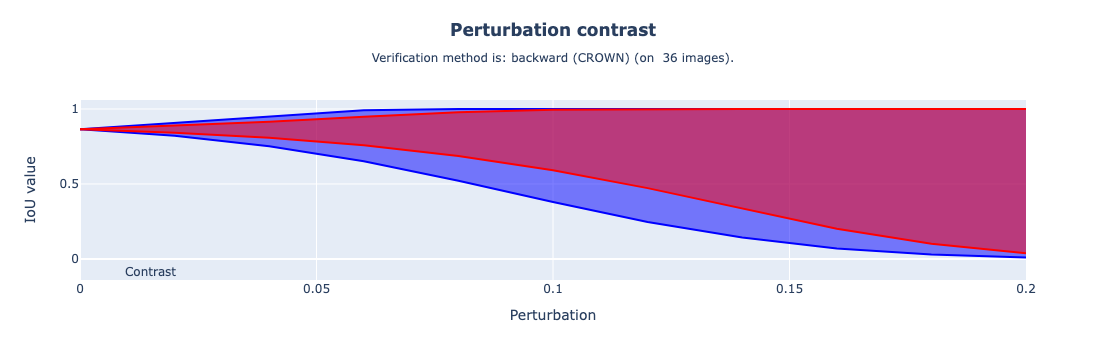

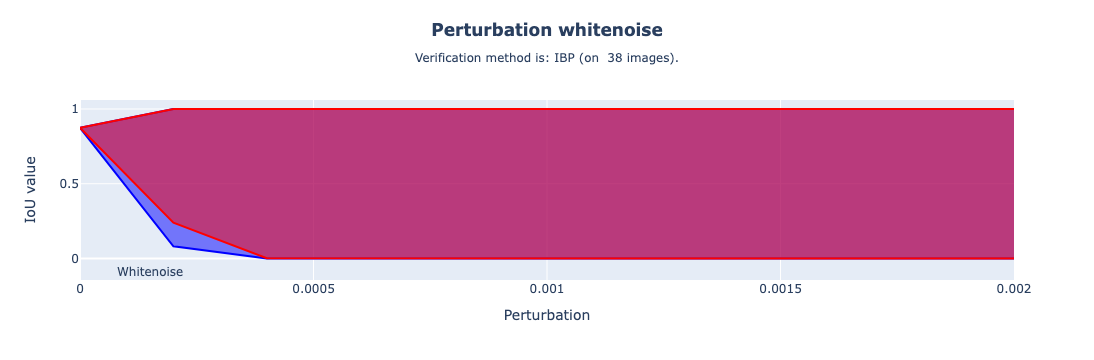

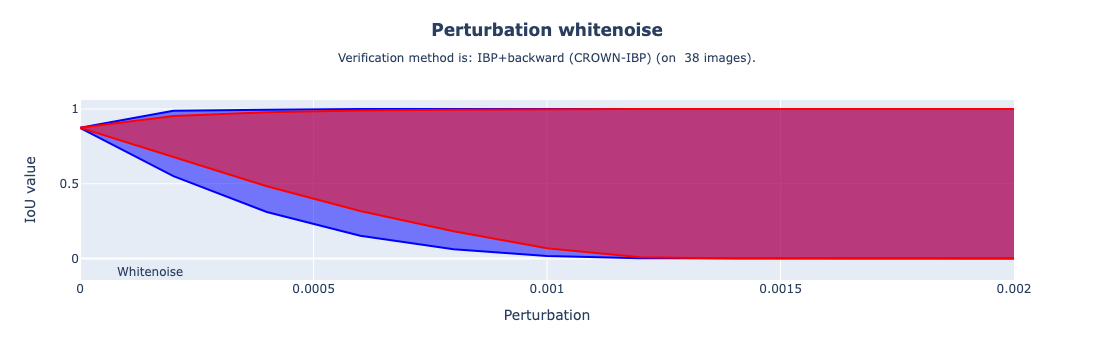

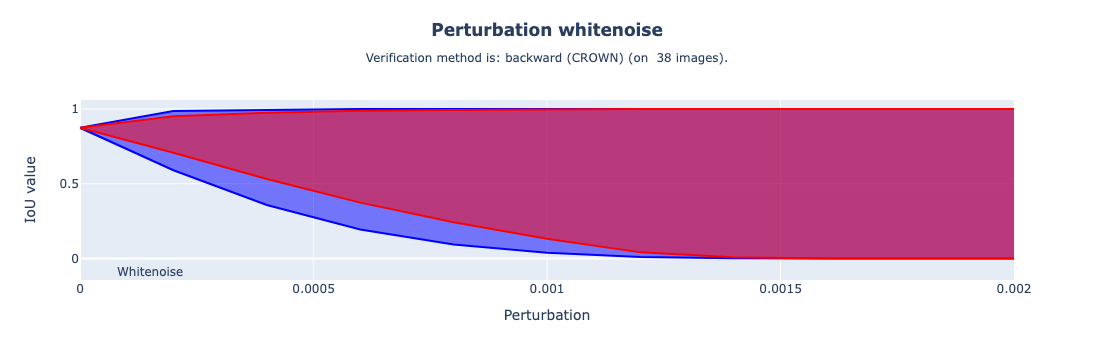

In [133]:
fig_pert_dict = {'brightness':[], 'contrast':[], 'whitenoise':[]}
for pert, eps_type in eps_pert_dict.items():
    for method in np.unique(combined_df.method):
        df_grouped = combined_df[(combined_df["perturbation"] == pert) & (combined_df["method"] == method)].groupby(["eps"] )[["Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"]].agg("mean")
        df_grouped = df_grouped.reset_index()
        nb_im_proc = combined_df[(combined_df["perturbation"] == pert) & (combined_df["method"] == method)].groupby("image_id")[["eps"]].agg("count").shape[0]
        fig = envelop_graph(df_grouped, eps=eps_type, title=f'Perturbation {pert}', subtitle=f"Verification method is: {method} (on  {nb_im_proc} images).", annotations=pretty_names[pert])
        fig.show()
        anotations = fig['layout']['annotations']
        fig_pert_dict[pert].append((fig.data, method, anotations))

In [134]:
fig_pert_dict_subplot = {}

for pert in fig_pert_dict.keys():
    fig = make_subplots(rows=3, cols=1, vertical_spacing=0.02)
    for i in range(len(fig_pert_dict[pert])):
        fig_i, method_i, annotation_i = fig_pert_dict[pert][i][0], fig_pert_dict[pert][i][1], fig_pert_dict[pert][i][2]
        for trace in fig_i:
            fig.add_trace(trace, row=1+i, col=1)
            fig.update_yaxes(title_text=method_i, row=1+i, col=1)
            
                
            #fig.update_layout(annotations=annotation_i)
            #fig['layout']['annotations'] = annotation_i
    fig.update_layout(height=1000, width=800)
    fig.update_xaxes(title_text=f"{pretty_names[pert]} perturbation", row=3, col=1)
    fig_pert_dict_subplot[pert] = fig

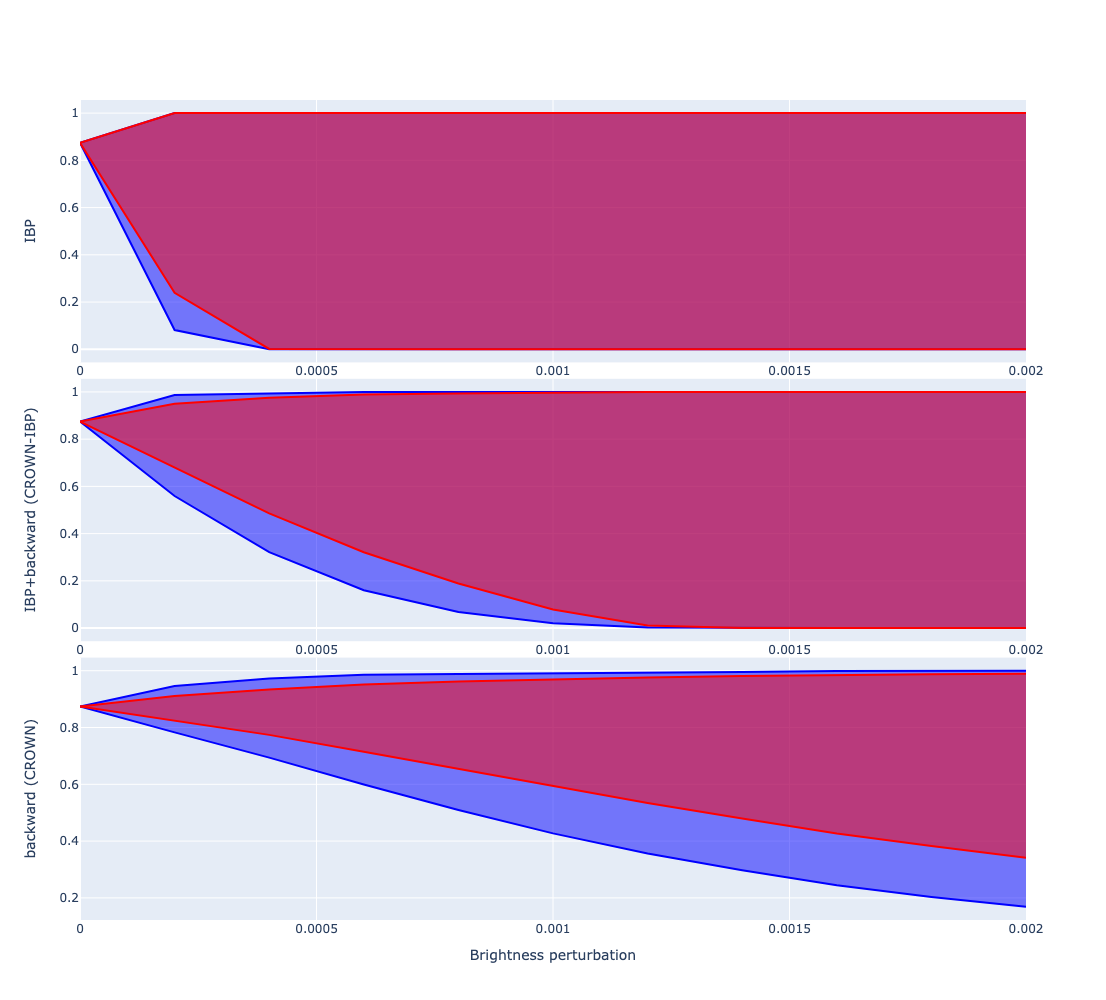

In [135]:
fig_1 = fig_pert_dict_subplot['brightness']
fig_1

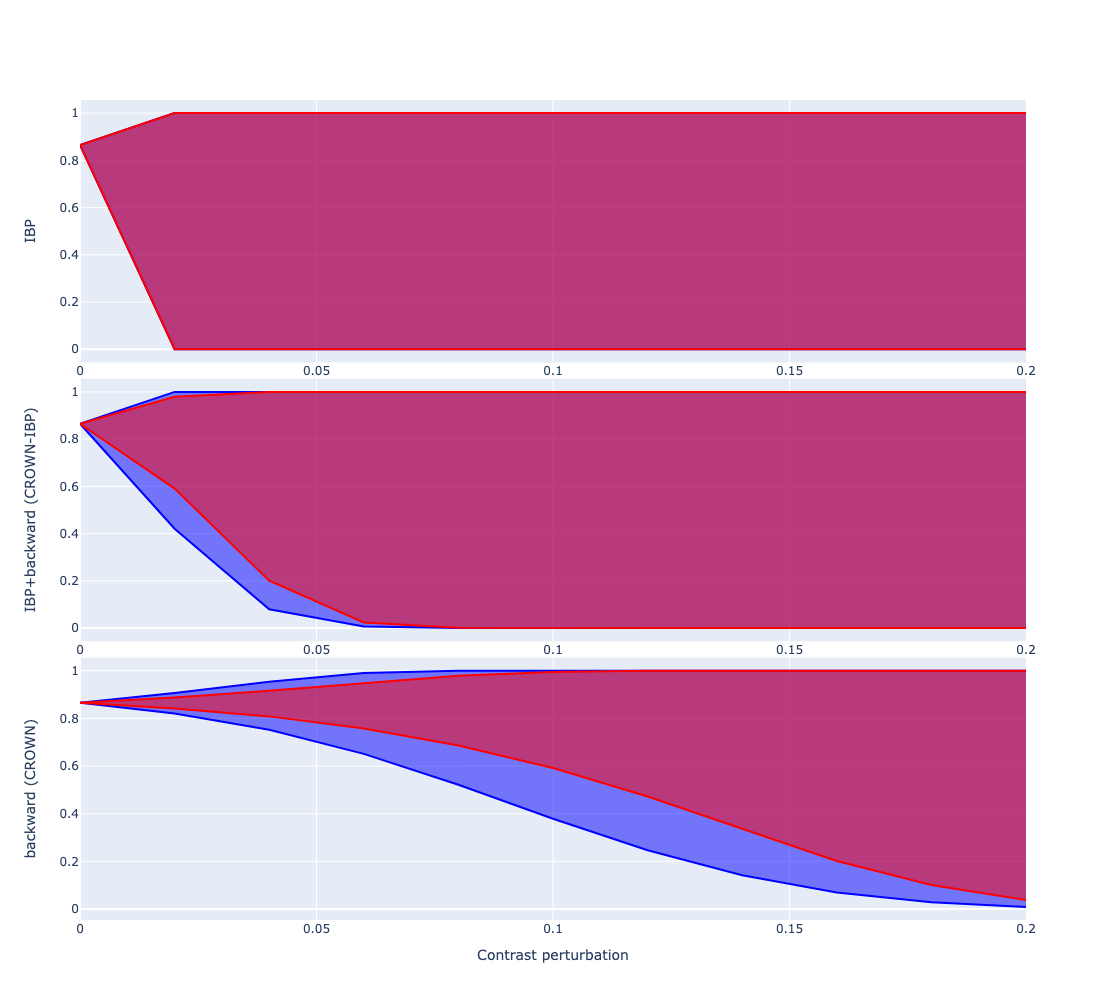

In [136]:
fig_pert_dict_subplot['contrast']

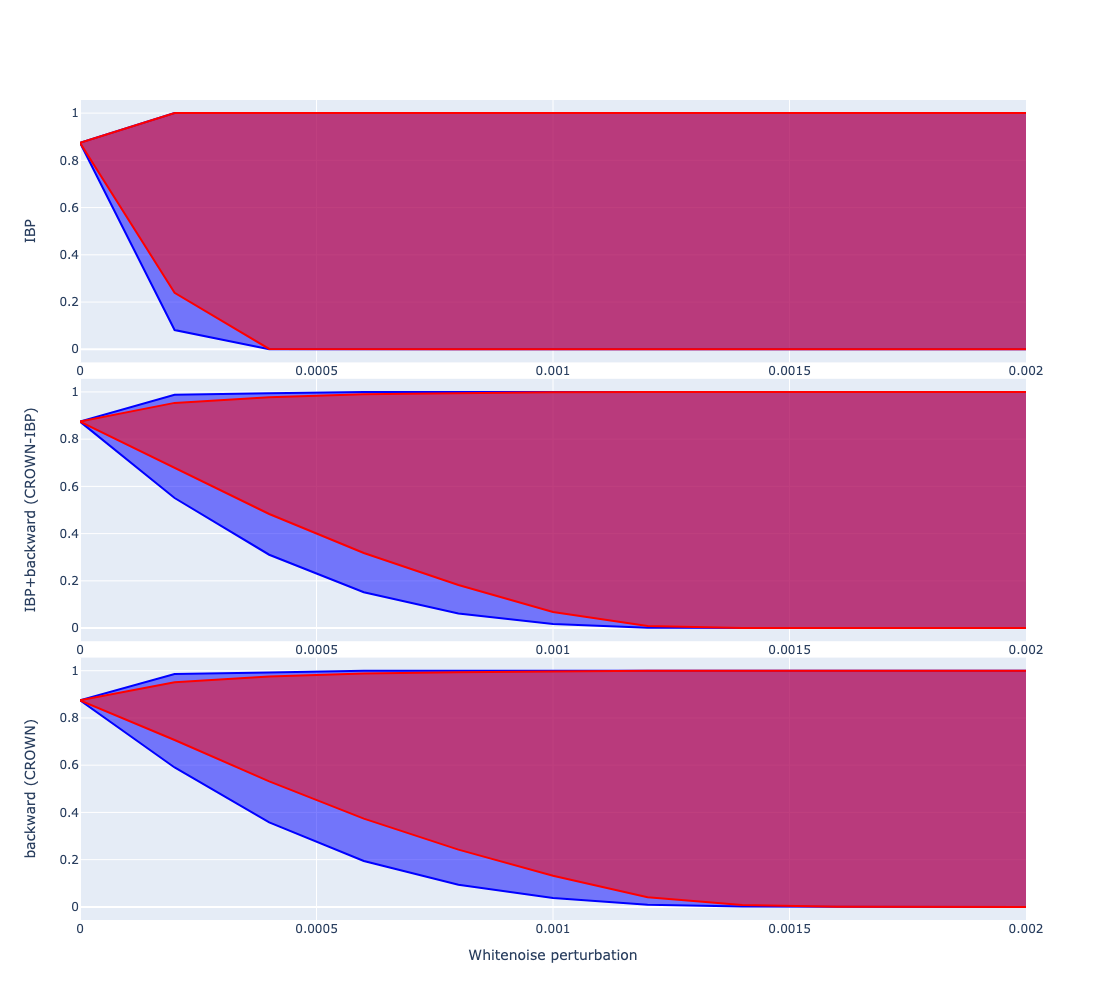

In [137]:
fig_pert_dict_subplot['whitenoise']

## MNIST characterisation with CROWN

In [138]:
fig_pert_dict['brightness'][2][0], fig_pert_dict['brightness'][2][1]

((Scatter({
      'line': {'color': 'blue'},
      'mode': 'lines',
      'name': 'Vanilla_IoU Upper Bound',
      'showlegend': False,
      'x': array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014, 0.0016,
                  0.0018, 0.002 ]),
      'y': array([0.87434379, 0.94608619, 0.97273293, 0.9859445 , 0.98875773, 0.99058328,
                  0.99282742, 0.99547705, 0.99894554, 1.        , 1.        ])
  }),
  Scatter({
      'fill': 'tonexty',
      'line': {'color': 'blue'},
      'mode': 'lines',
      'name': 'Vanilla_IoU Lower Bound',
      'showlegend': False,
      'x': array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014, 0.0016,
                  0.0018, 0.002 ]),
      'y': array([0.87434379, 0.78275728, 0.69401334, 0.5990247 , 0.50963725, 0.42721985,
                  0.35615026, 0.29716452, 0.24475436, 0.20298267, 0.16831294])
  }),
  Scatter({
      'line': {'color': 'red'},
      'mode': 'lines',
      'name': 'IoU_extension Upper

In [139]:
fig_pert_dict['whitenoise'][2][0], fig_pert_dict['whitenoise'][2][1]

((Scatter({
      'line': {'color': 'blue'},
      'mode': 'lines',
      'name': 'Vanilla_IoU Upper Bound',
      'showlegend': False,
      'x': array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014, 0.0016,
                  0.0018, 0.002 ]),
      'y': array([0.87434379, 0.986116  , 0.99271937, 1.        , 1.        , 1.        ,
                  1.        , 1.        , 1.        , 1.        , 1.        ])
  }),
  Scatter({
      'fill': 'tonexty',
      'line': {'color': 'blue'},
      'mode': 'lines',
      'name': 'Vanilla_IoU Lower Bound',
      'showlegend': False,
      'x': array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014, 0.0016,
                  0.0018, 0.002 ]),
      'y': array([8.74343791e-01, 5.90415309e-01, 3.57730500e-01, 1.94354290e-01,
                  9.35304570e-02, 3.80125418e-02, 9.22677051e-03, 1.51390284e-03,
                  2.32924192e-05, 0.00000000e+00, 0.00000000e+00])
  }),
  Scatter({
      'line': {'color': 're

In [140]:
fig_pert_dict['contrast'][2][0], fig_pert_dict['contrast'][2][1]

((Scatter({
      'line': {'color': 'blue'},
      'mode': 'lines',
      'name': 'Vanilla_IoU Upper Bound',
      'showlegend': False,
      'x': array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
      'y': array([0.86512596, 0.90692341, 0.95334644, 0.99083651, 1.        , 1.        ,
                  1.        , 1.        , 1.        , 1.        , 1.        ])
  }),
  Scatter({
      'fill': 'tonexty',
      'line': {'color': 'blue'},
      'mode': 'lines',
      'name': 'Vanilla_IoU Lower Bound',
      'showlegend': False,
      'x': array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
      'y': array([0.86512596, 0.82072521, 0.75207576, 0.65094564, 0.52156815, 0.37906378,
                  0.24674351, 0.1418806 , 0.06973612, 0.02894545, 0.0090408 ])
  }),
  Scatter({
      'line': {'color': 'red'},
      'mode': 'lines',
      'name': 'IoU_extension Upper Bound',
      'showlegend': False,
      'x': array([0.  , 0.02, 0.04, 0.06, 0.

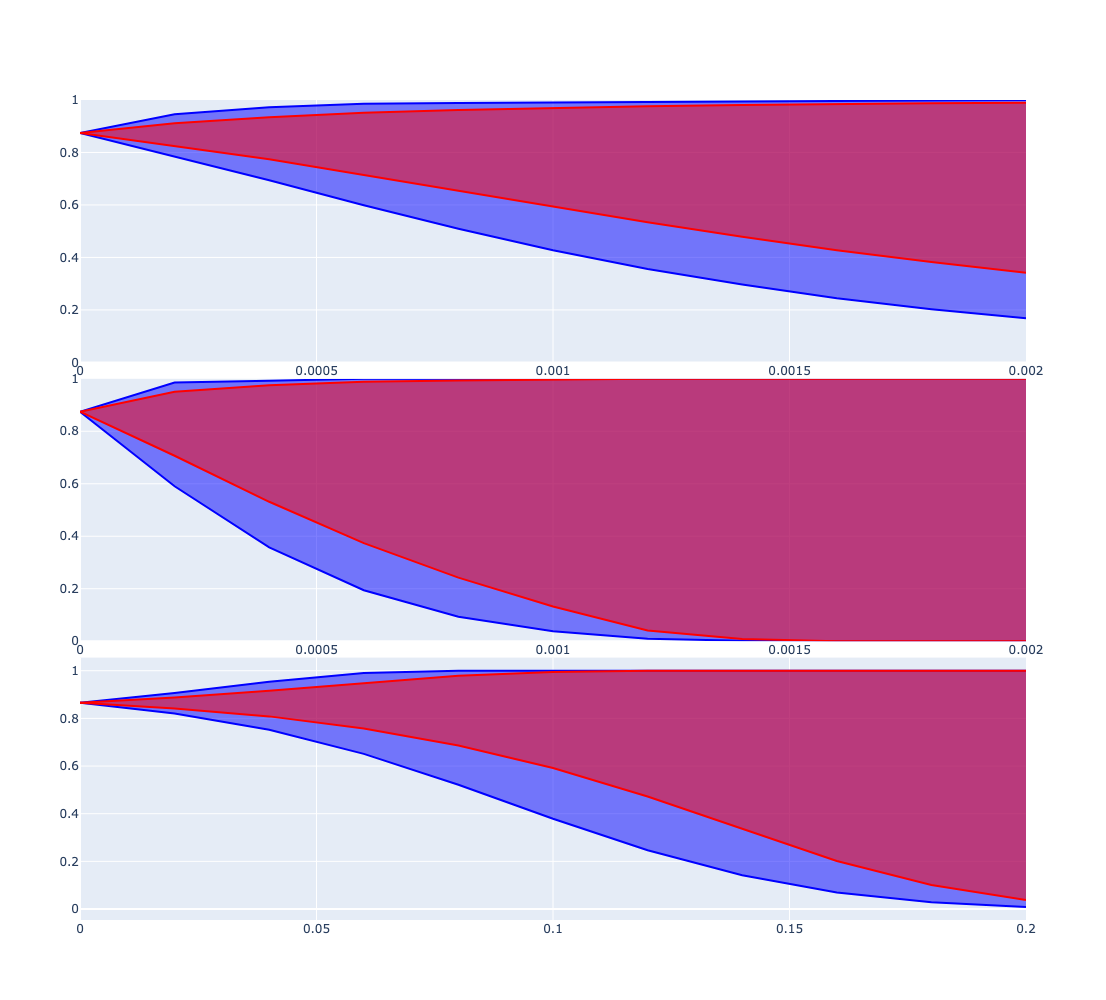

In [141]:
fig_pert_dict['brightness'][2][0], fig_pert_dict['brightness'][2][1]



fig = make_subplots(rows=3, cols=1, vertical_spacing=0.02)

fig_whitenoise_crown = fig_pert_dict['whitenoise'][2][0]
for trace in fig_whitenoise_crown: 
    fig.add_trace(trace, row=2, col=1)
fig.update_yaxes(range=[0,1], row=2, col=1)

fig_brightness_crown = fig_pert_dict['brightness'][2][0]
for trace in fig_brightness_crown:
    fig.add_trace(trace, row=1, col=1)
fig.update_yaxes(range=[0,1], row=1, col=1)




fig_contrast_crown = fig_pert_dict['contrast'][2][0]
for trace in fig_contrast_crown: 
    fig.add_trace(trace, row=3, col=1)
#fig.update_yaxes(range=[0,1], row=3, col=1)


fig.update_layout(height=1000, width=800)
fig

# <a id="Time"></a> Time analysis

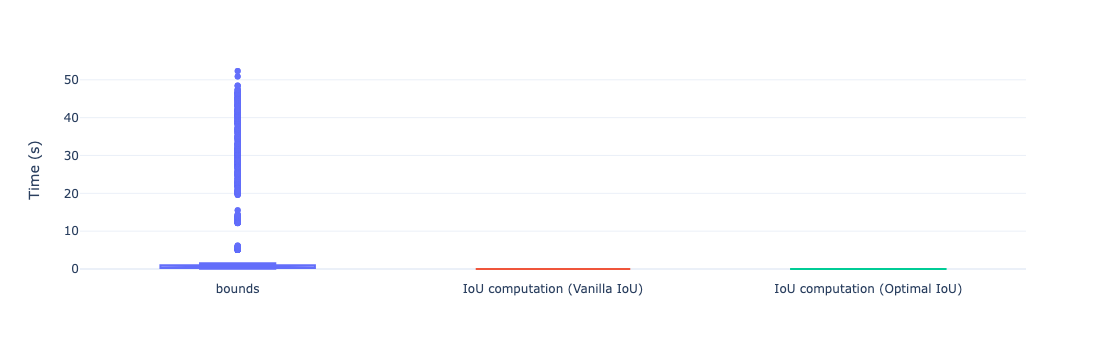

In [142]:
def create_box_plot(df, columns, return_V=False, without_melt=False, y_axes='Time (s)'):
    if without_melt==False:
        df = df.melt(value_vars=columns, var_name='Time', value_name='Value')
    fig = px.box(df, x='Time', y='Value', color='Time', 
                 notched=True,  
                 title='')

    fig.update_layout(
        yaxis_title=y_axes,  
        xaxis_title='',
        template='plotly_white',  
        showlegend=False  
    )
    if return_V==True:
        return(df)
    fig.show()

create_box_plot(combined_df.rename(columns={
    'elapsed_time_perturbation':'bounds',
    "tmps_vanilla":'IoU computation (Vanilla IoU)',
    "tmps_extension":'IoU computation (Optimal IoU)'}), ['bounds', 'IoU computation (Vanilla IoU)',	'IoU computation (Optimal IoU)'])

In [143]:
ious_ = create_box_plot(combined_df.rename(columns={
    "tmps_vanilla":'Vanilla IoU',
    "tmps_extension":'Optimal IoU'}), ['Optimal IoU', 'Vanilla IoU'], return_V=True)

df_CROWN_IBP = create_box_plot(combined_df[combined_df["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
    'elapsed_time_perturbation':'bounds (CROWN-IBP)',
    "tmps_vanilla":'Vanilla IoU',
    "tmps_extension":'Optimal IoU'}), ['bounds (CROWN-IBP)'], return_V=True)
df_CROWN = create_box_plot(combined_df[combined_df["method"] == 'backward (CROWN)'].rename(columns={
    'elapsed_time_perturbation':'bounds (CROWN)',
    "tmps_vanilla":'Vanilla IoU',
    "tmps_extension":'Optimal IoU'}), ['bounds (CROWN)'], return_V=True)
df_IBP = create_box_plot(combined_df[combined_df["method"] == 'IBP'].rename(columns={
    'elapsed_time_perturbation':'bounds (IBP)',
    "tmps_vanilla":'Vanilla IoU',
    "tmps_extension":'Optimal IoU'}), ['bounds (IBP)'], return_V=True)

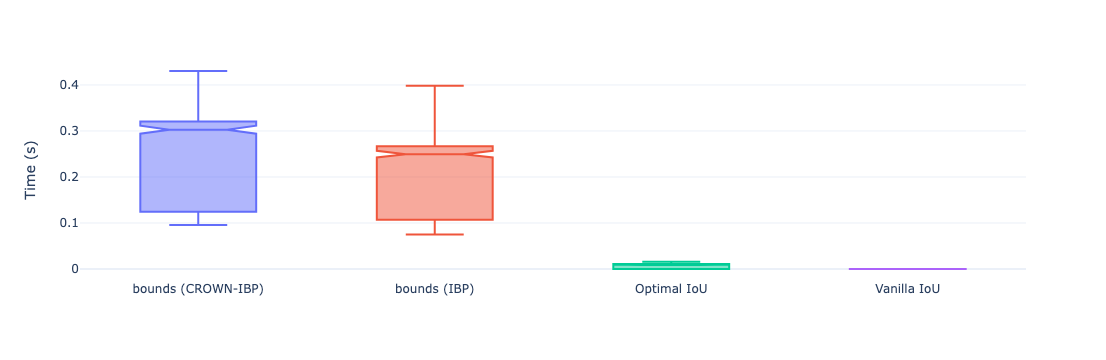

In [144]:
concat_methods = pd.concat([df_CROWN_IBP,df_IBP, ious_])
create_box_plot(concat_methods, columns=[""], return_V=False, without_melt=True)

epsilon 0.0


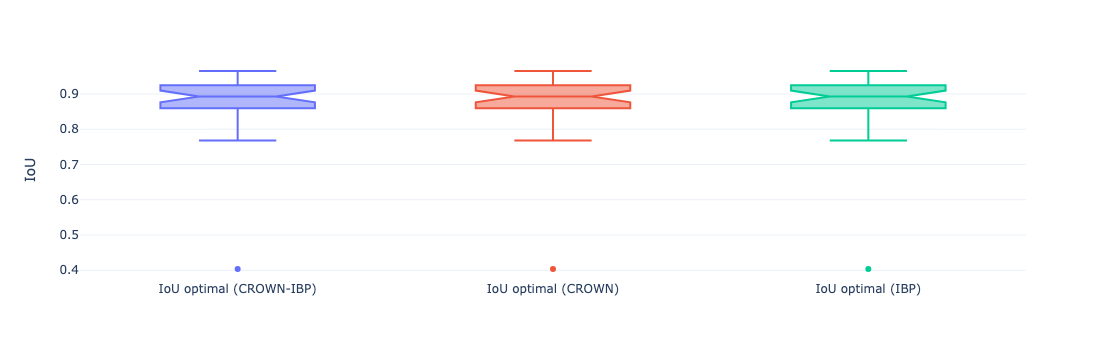

epsilon 0.0002


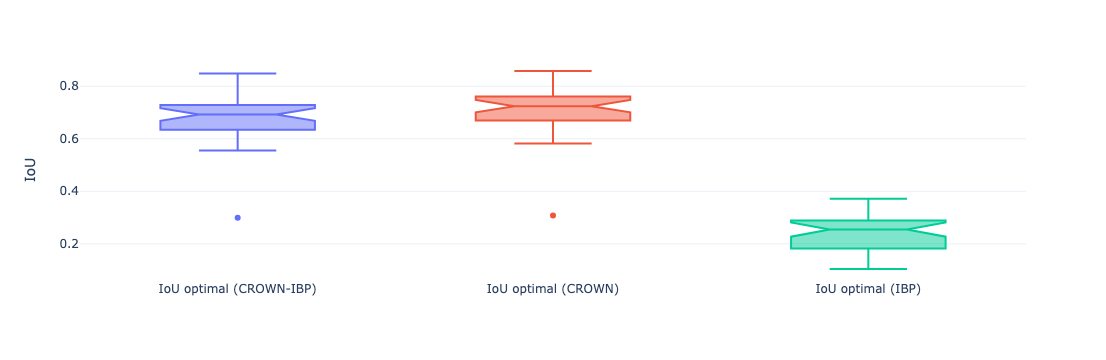

epsilon 0.0004


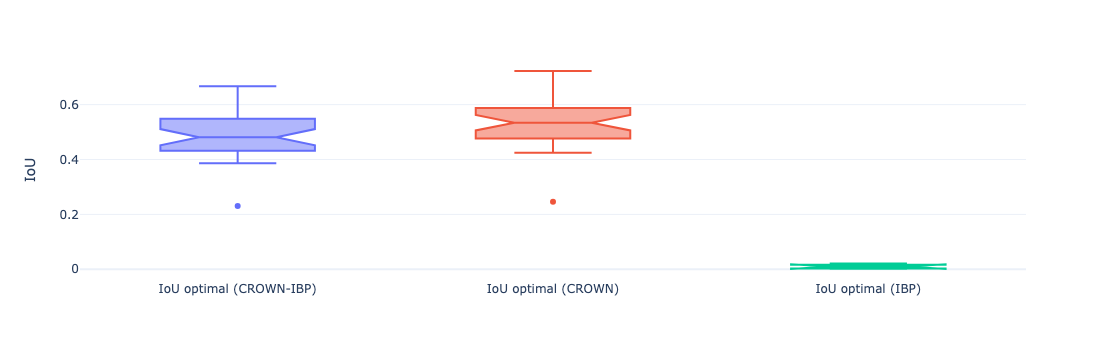

epsilon 0.0006


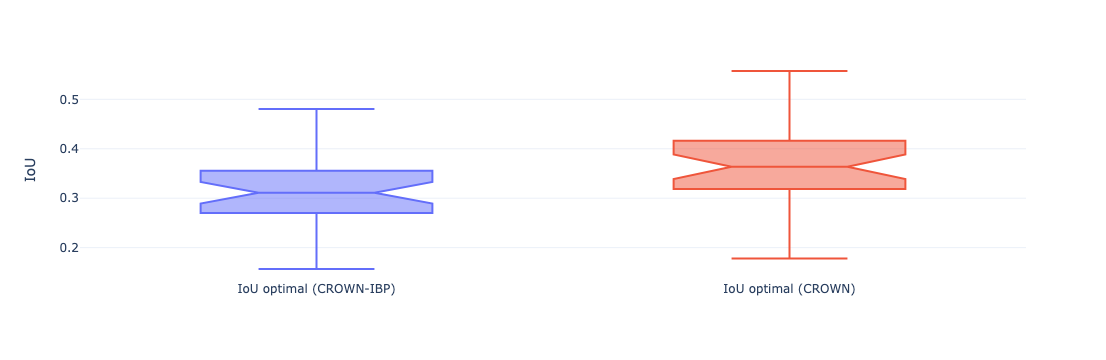

epsilon 0.0008


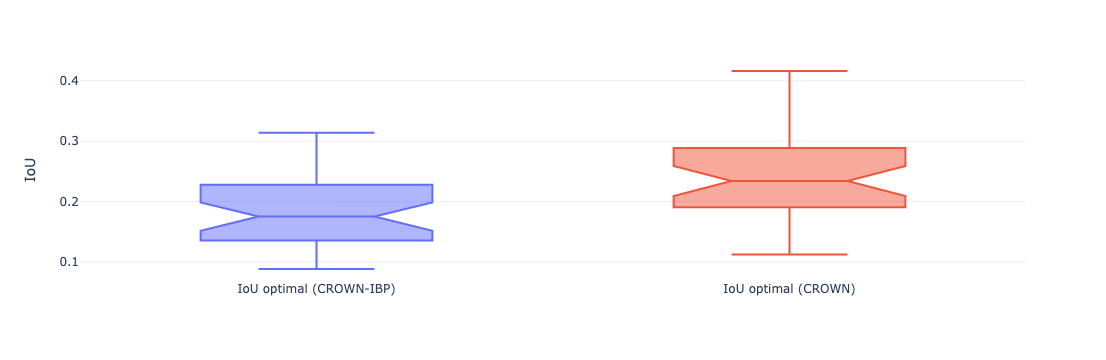

epsilon 0.001


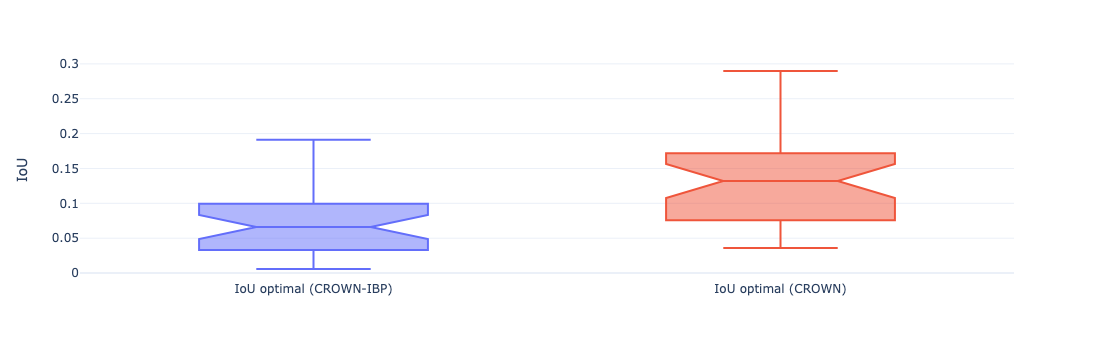

epsilon 0.0012


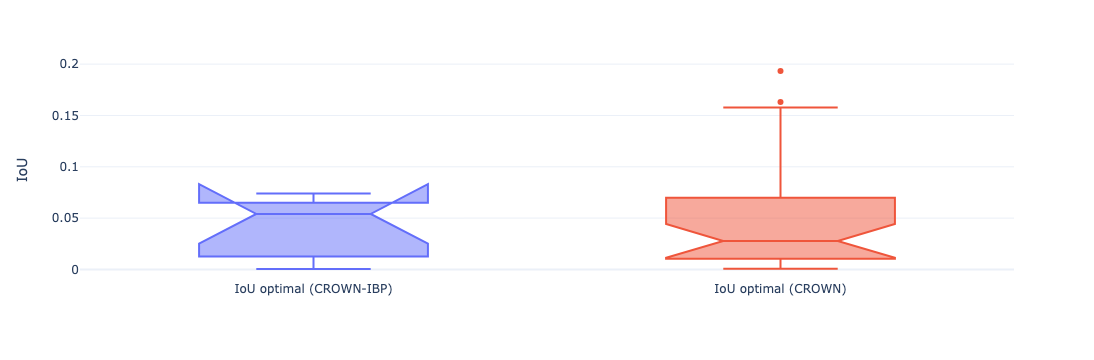

epsilon 0.0014


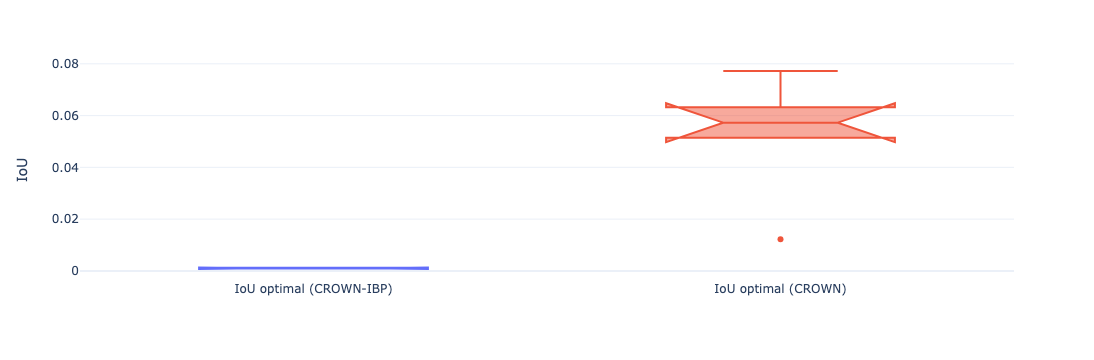

epsilon 0.0016


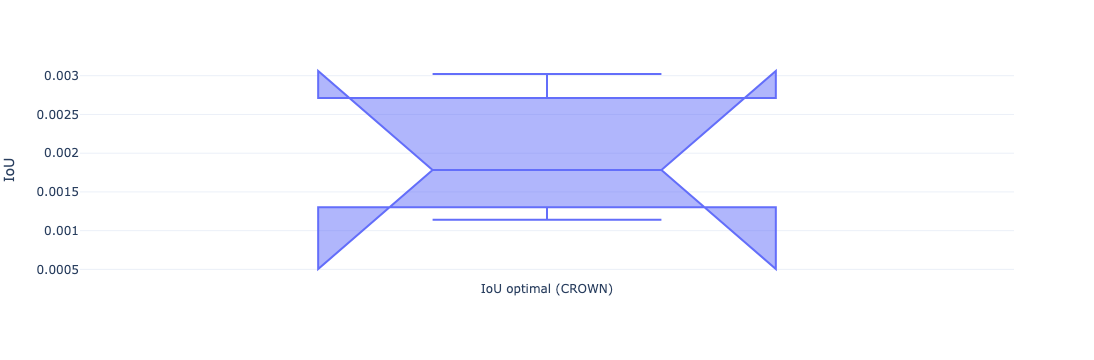

epsilon 0.0018


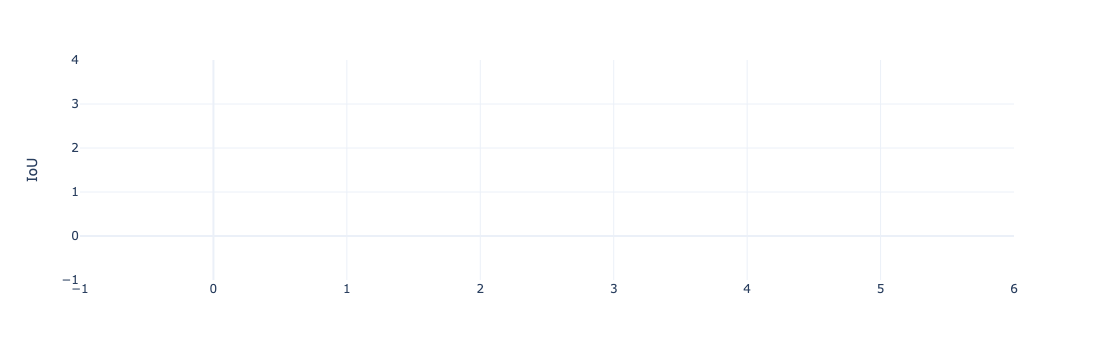

epsilon 0.002


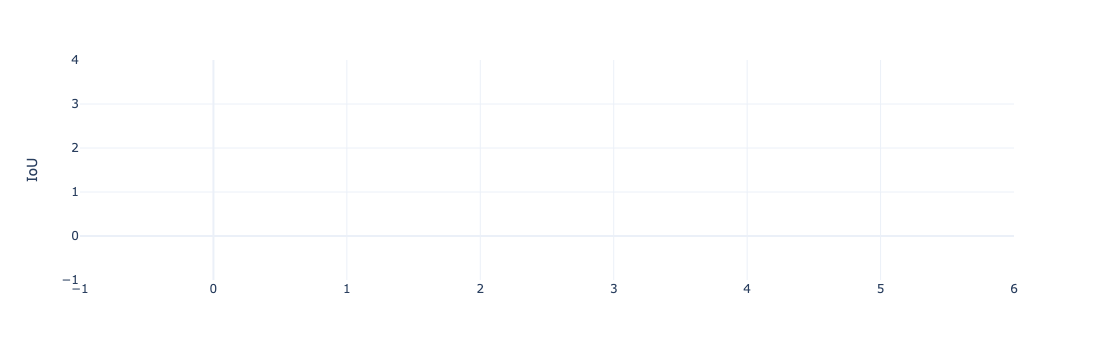

epsilon 0.02


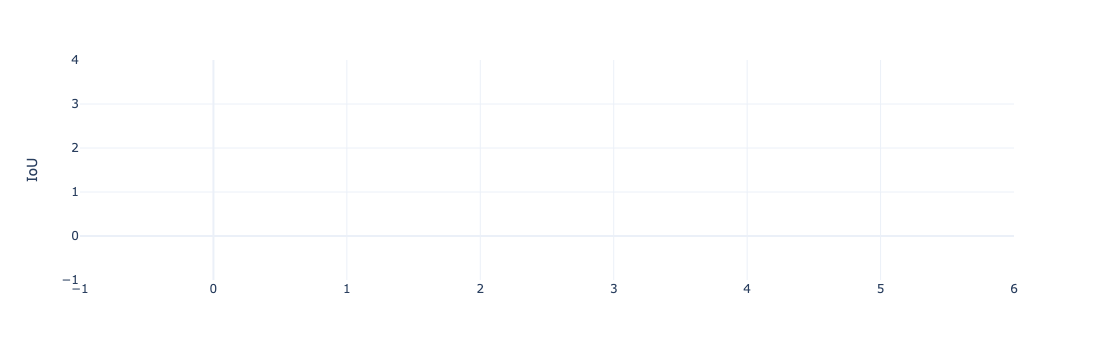

epsilon 0.04


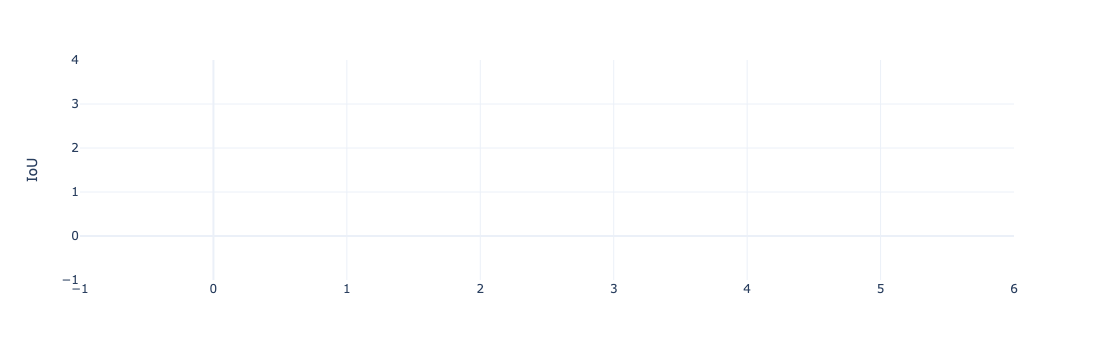

epsilon 0.06


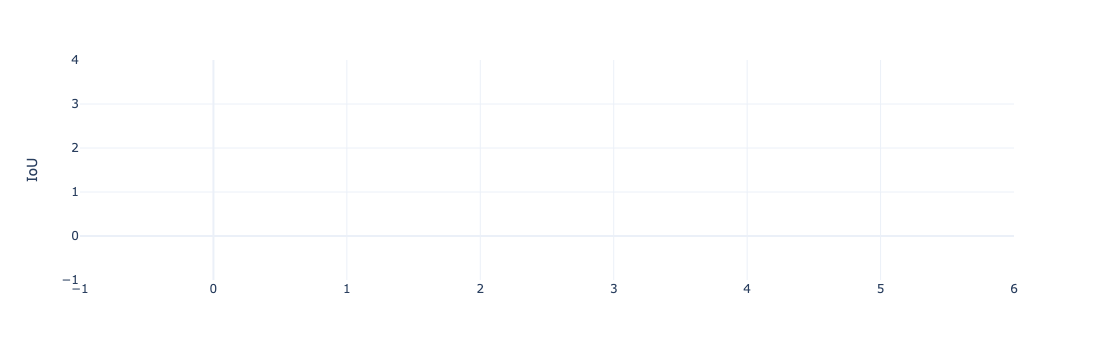

epsilon 0.08


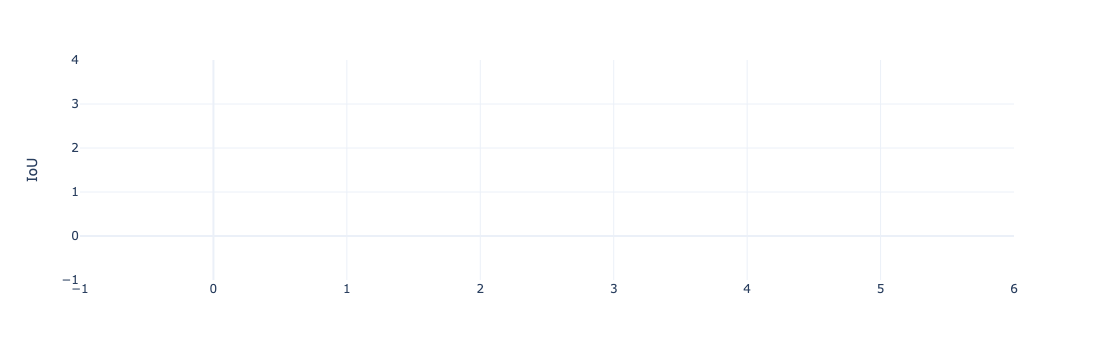

epsilon 0.1


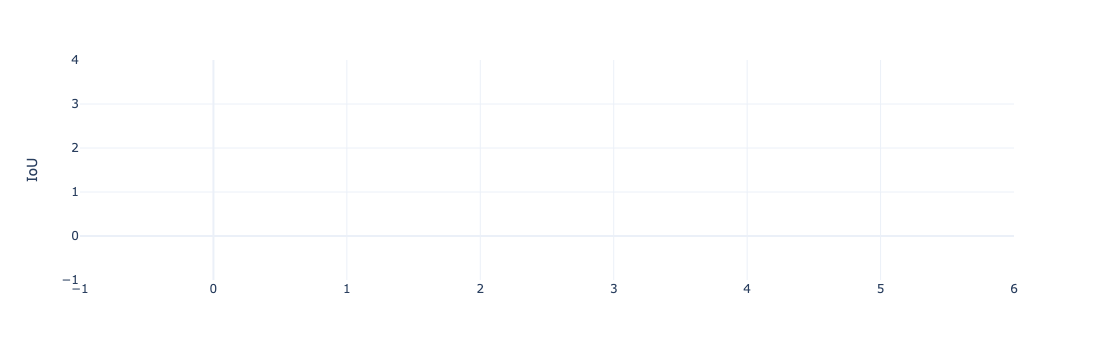

epsilon 0.12


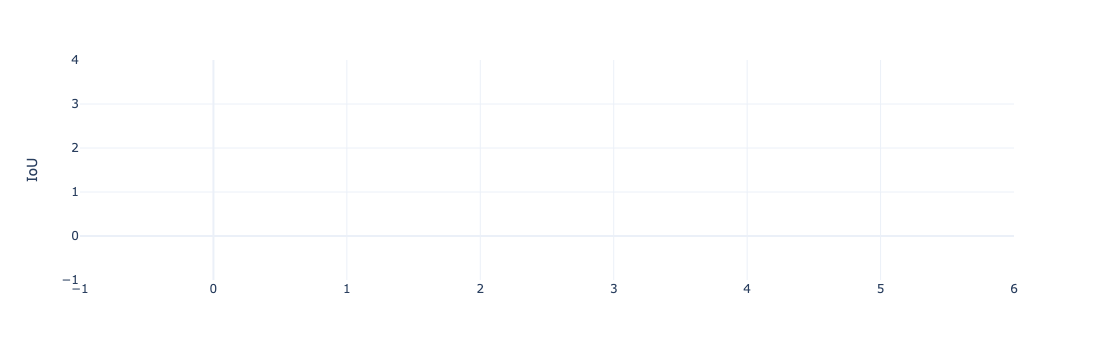

epsilon 0.14


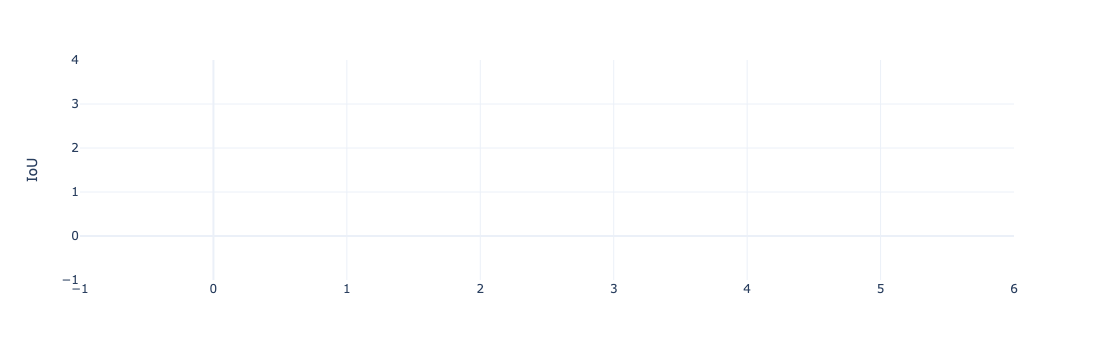

epsilon 0.16


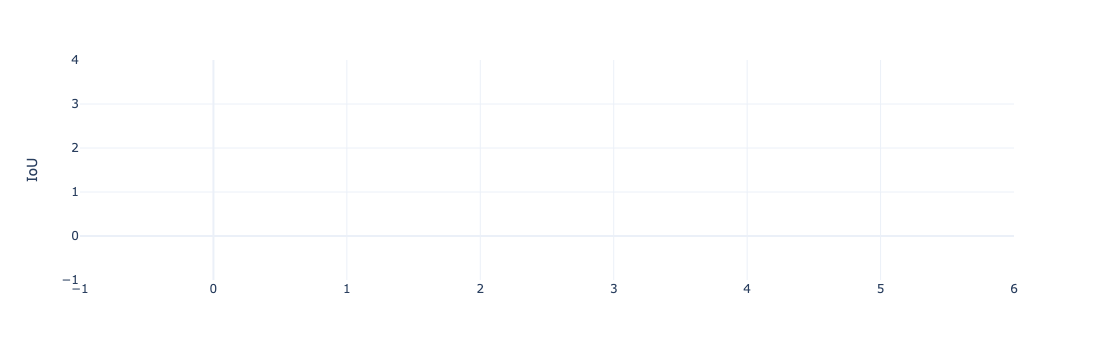

epsilon 0.18


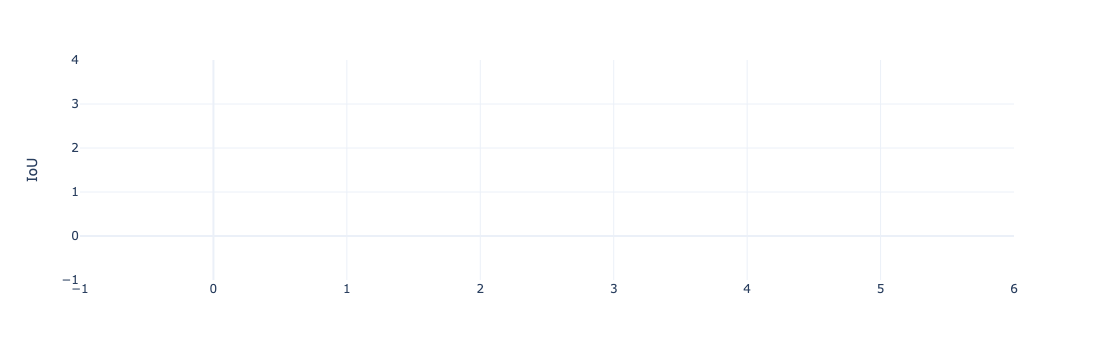

epsilon 0.2


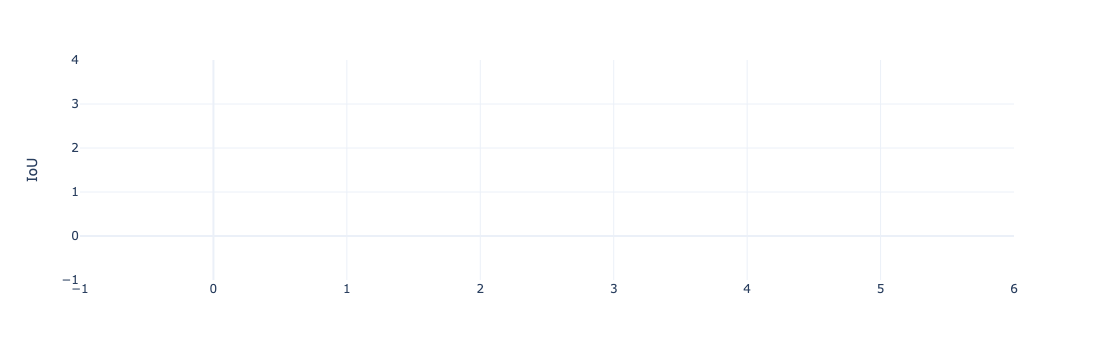

In [145]:
for eps in np.unique(combined_df["eps"]):
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==eps) & (combined_df["perturbation"]=="whitenoise")]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN-IBP)'}), ['IoU optimal (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN)'}), ['IoU optimal (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_lower":'IoU optimal (IBP)'}), ['IoU optimal (IBP)'], return_V=True)
    
    ious = pd.concat([df_CROWN_IBP_iou, df_CROWN_iou, df_IBP_iou])
    
    create_box_plot(ious, columns=[""], return_V=False, without_melt=True, y_axes='IoU')

epsilon 0.0


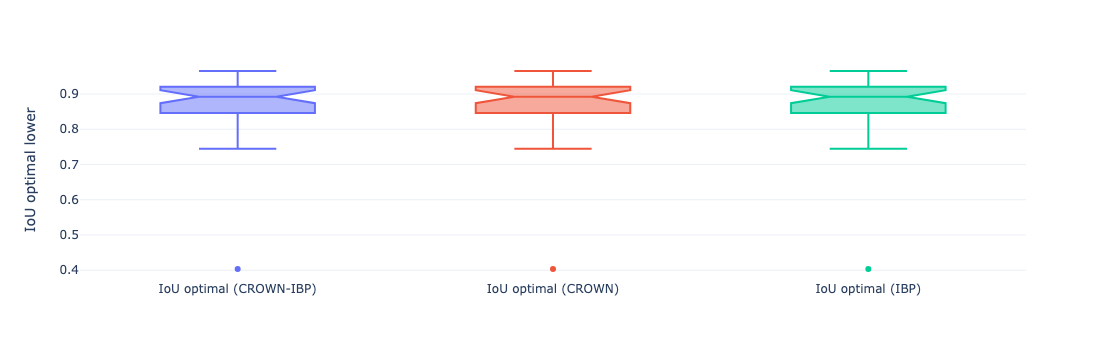

epsilon 0.0002


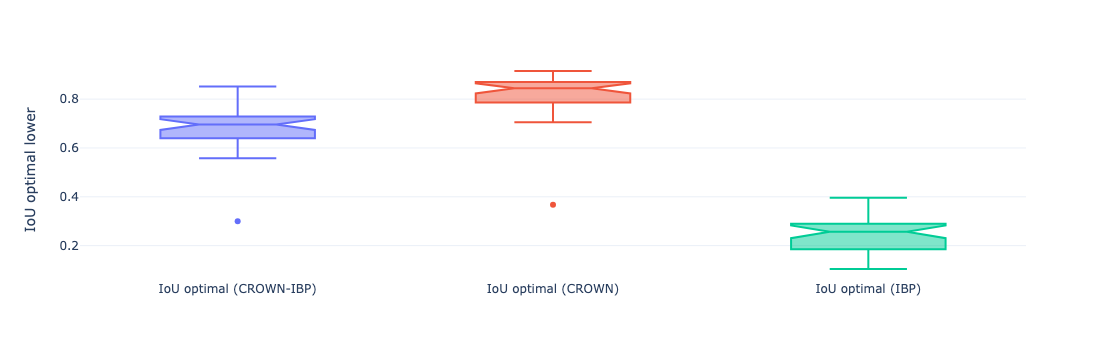

epsilon 0.0004


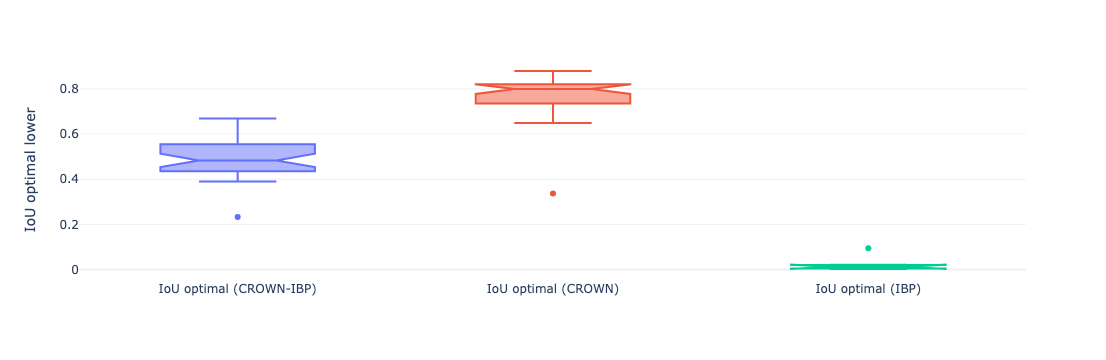

epsilon 0.0006


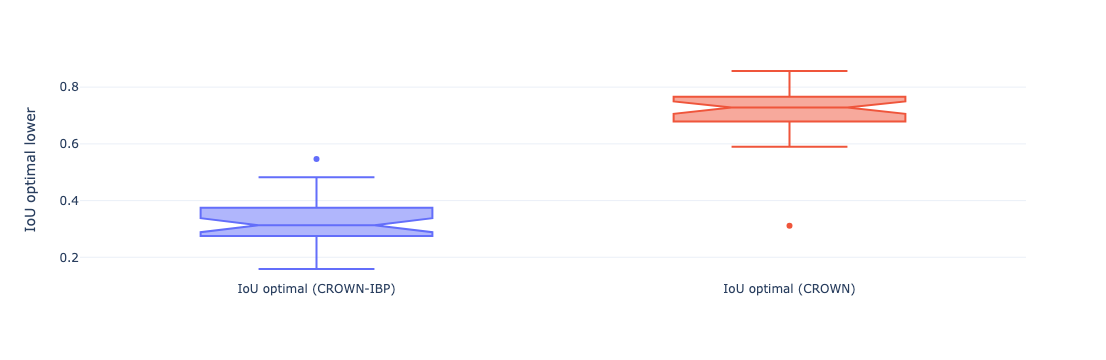

epsilon 0.0008


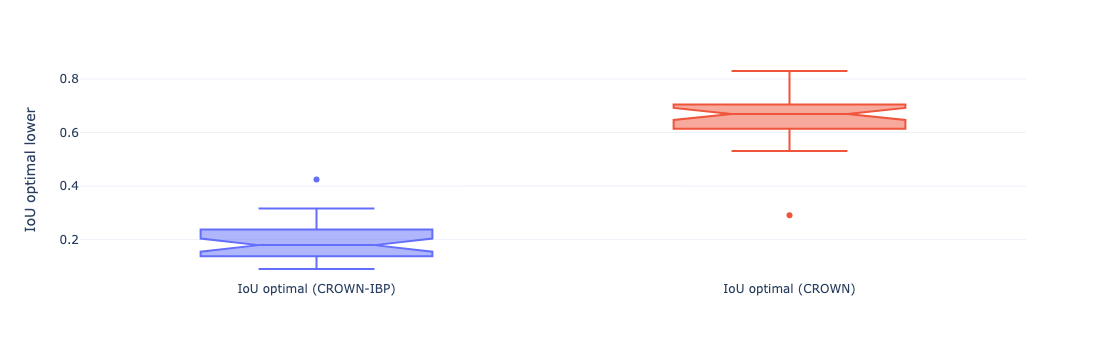

epsilon 0.001


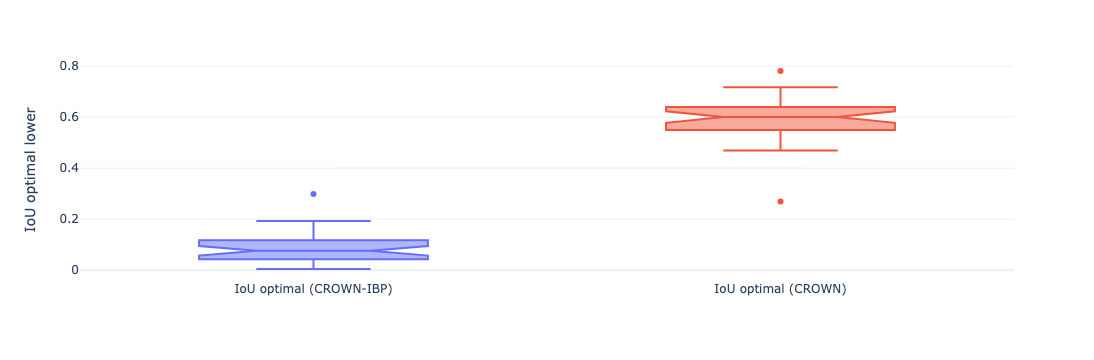

epsilon 0.0012


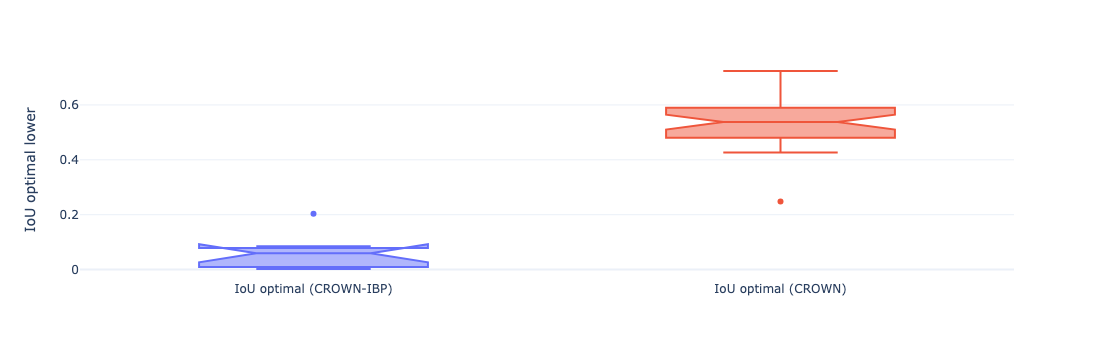

epsilon 0.0014


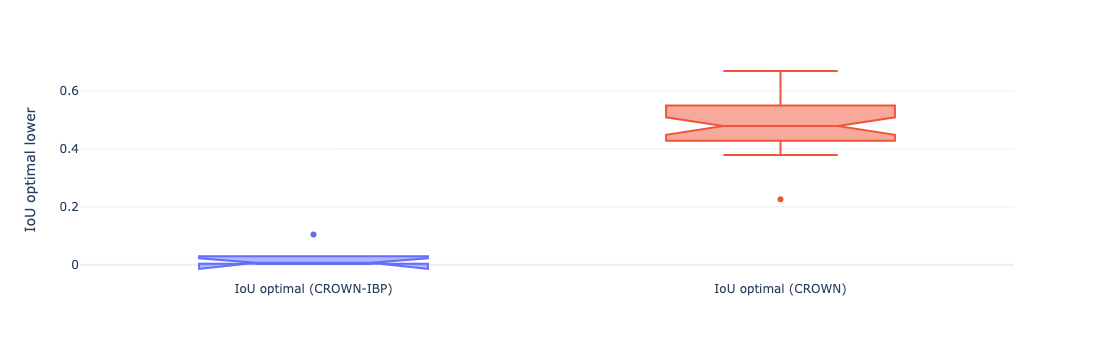

epsilon 0.0016


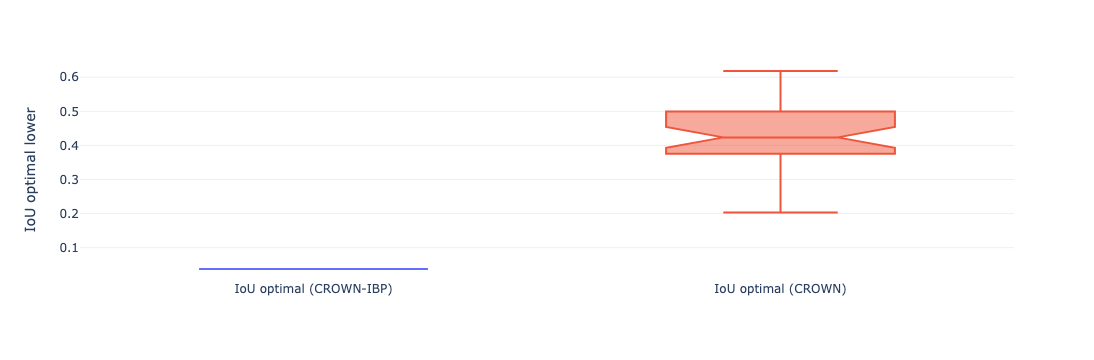

epsilon 0.0018


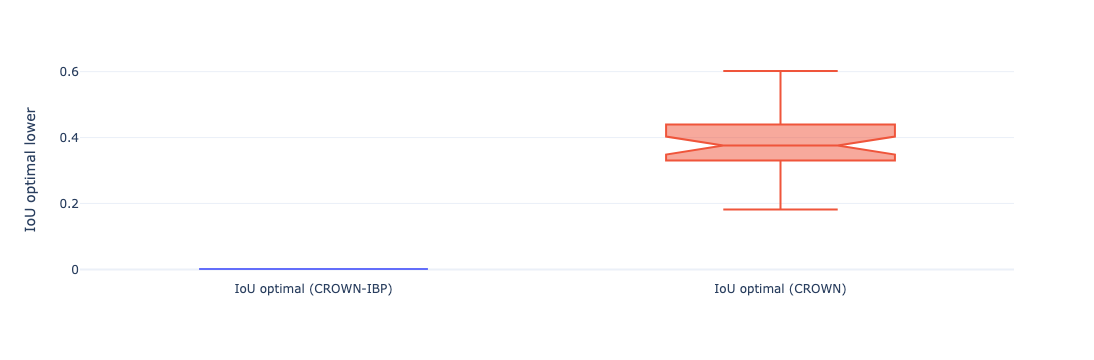

epsilon 0.002


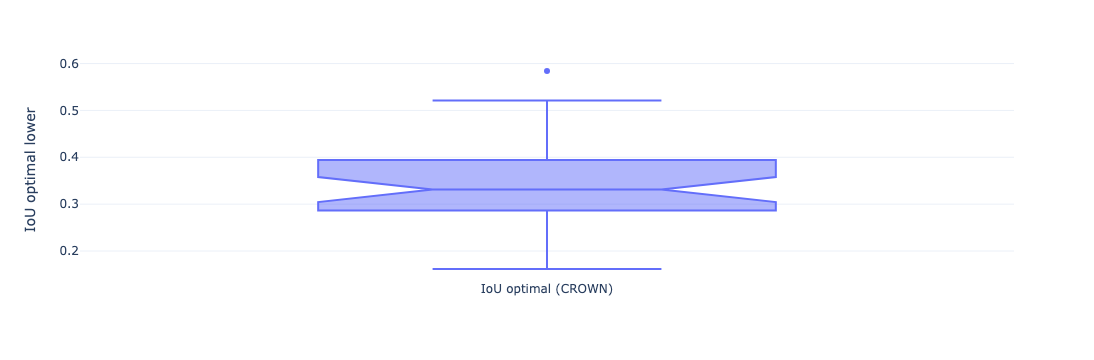

In [26]:

for eps in np.unique(combined_df["eps"]):
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==eps) & (combined_df["perturbation"]=="brightness")]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN-IBP)'}), ['IoU optimal (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN)'}), ['IoU optimal (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_lower":'IoU optimal (IBP)'}), ['IoU optimal (IBP)'], return_V=True)
    
    ious = pd.concat([df_CROWN_IBP_iou, df_CROWN_iou, df_IBP_iou])
    
    create_box_plot(ious, columns=[""], return_V=False, without_melt=True, y_axes='IoU optimal lower')

epsilon_contrast 0.0


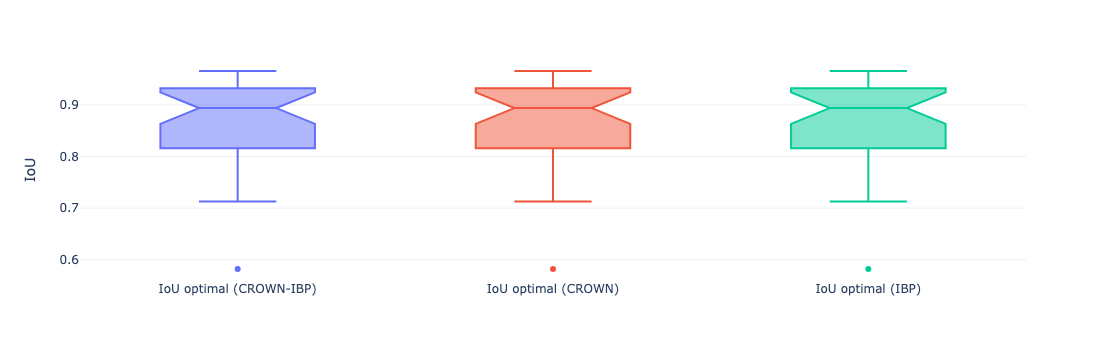

epsilon_contrast 0.0002


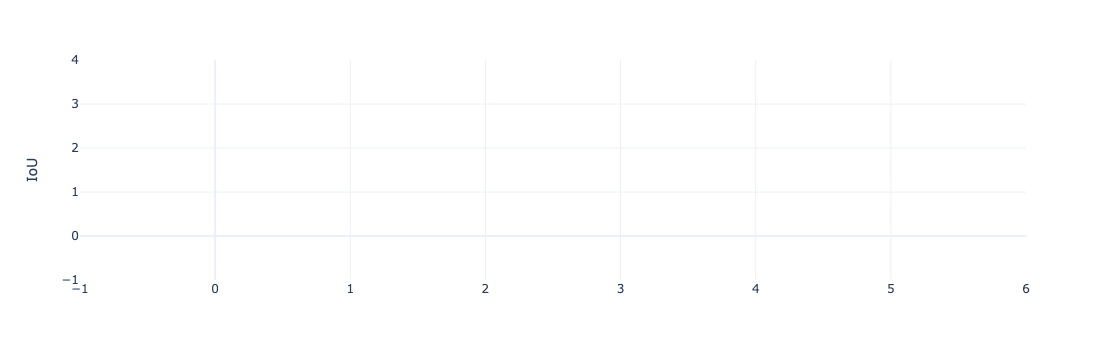

epsilon_contrast 0.0004


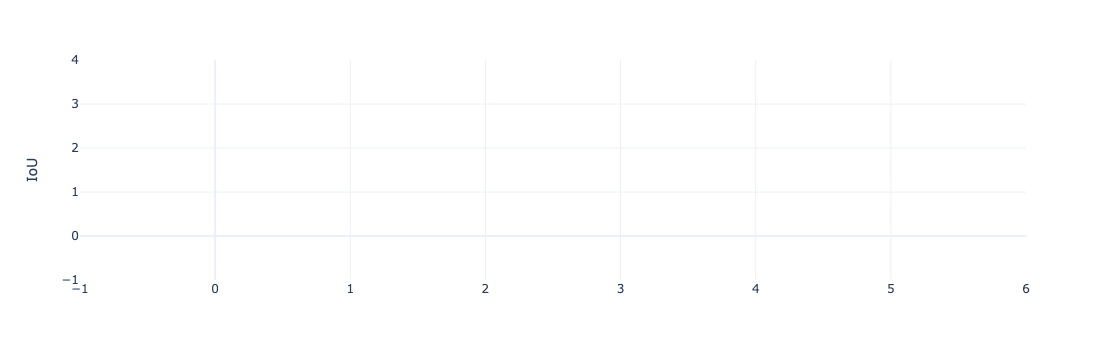

epsilon_contrast 0.0006


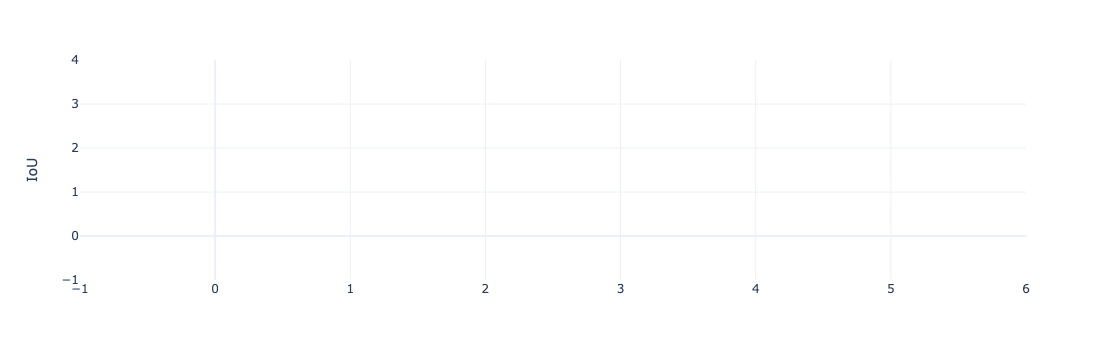

epsilon_contrast 0.0008


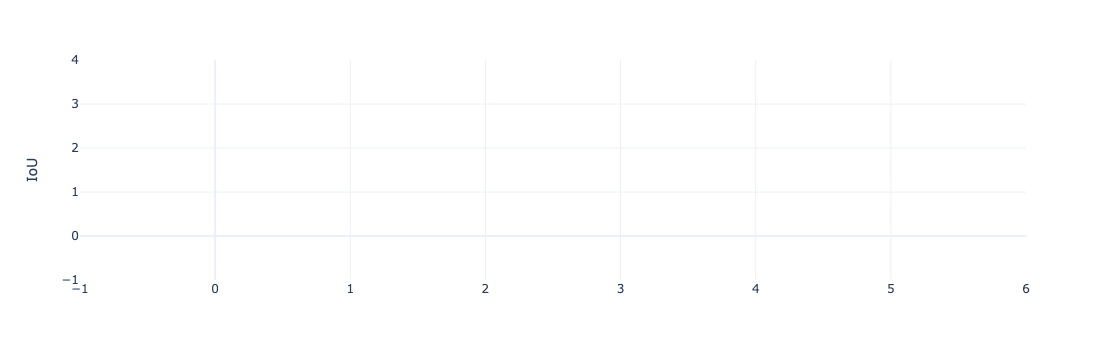

epsilon_contrast 0.001


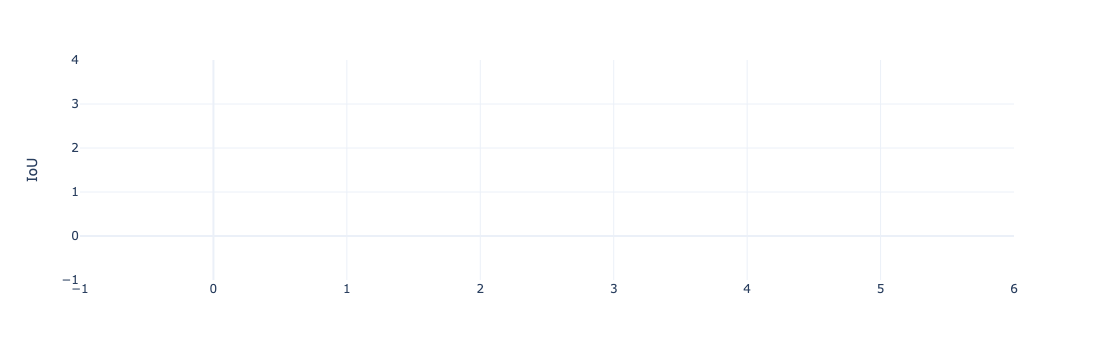

epsilon_contrast 0.0012


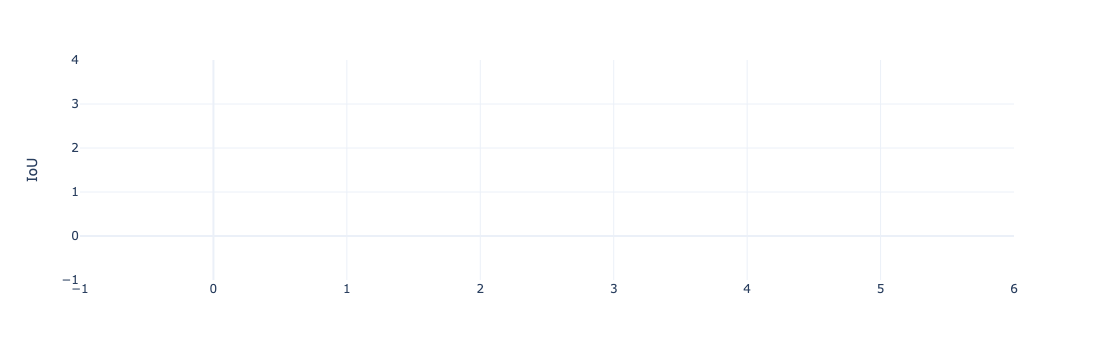

epsilon_contrast 0.0014


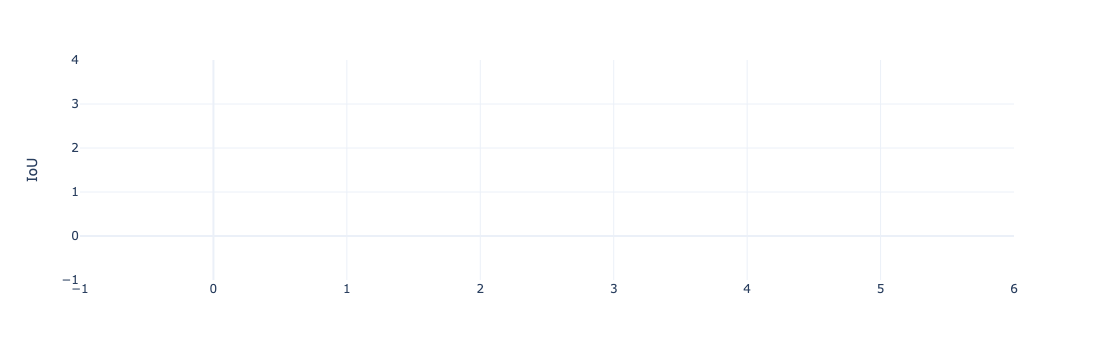

epsilon_contrast 0.0016


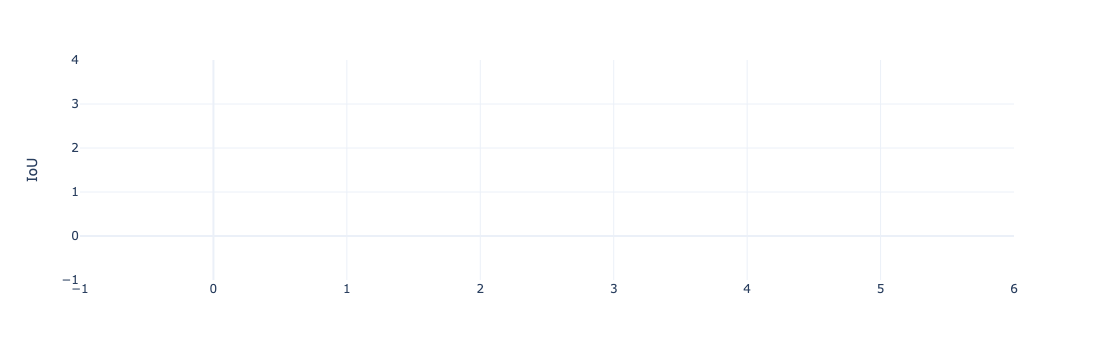

epsilon_contrast 0.0018


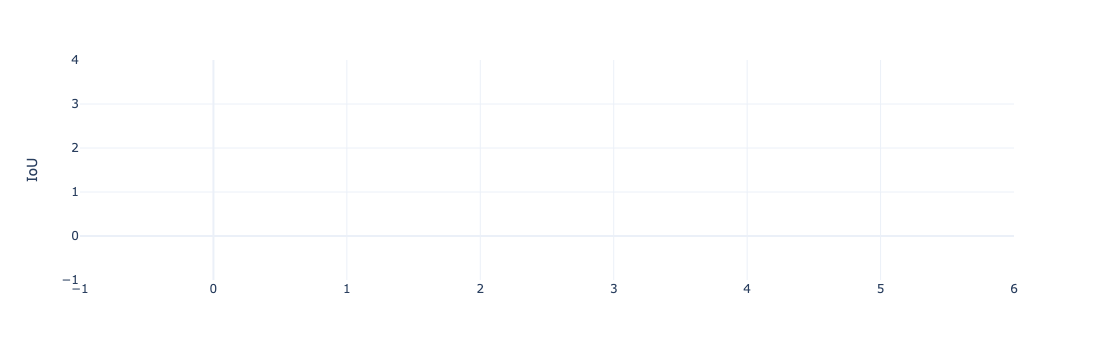

epsilon_contrast 0.002


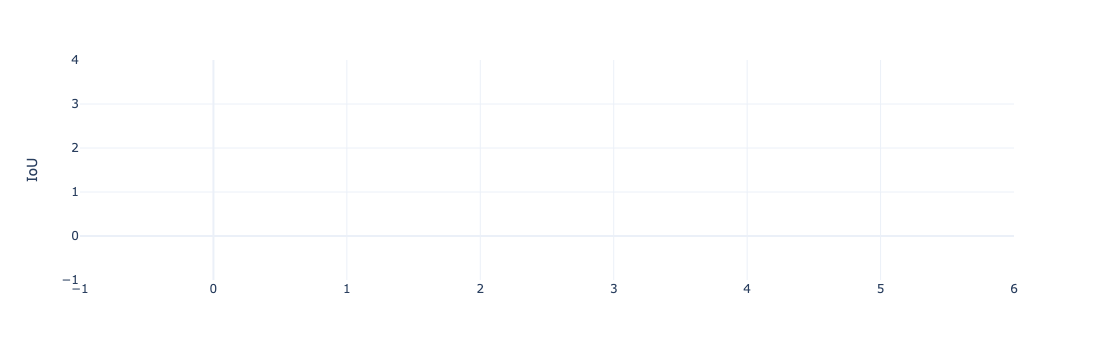

epsilon_contrast 0.02


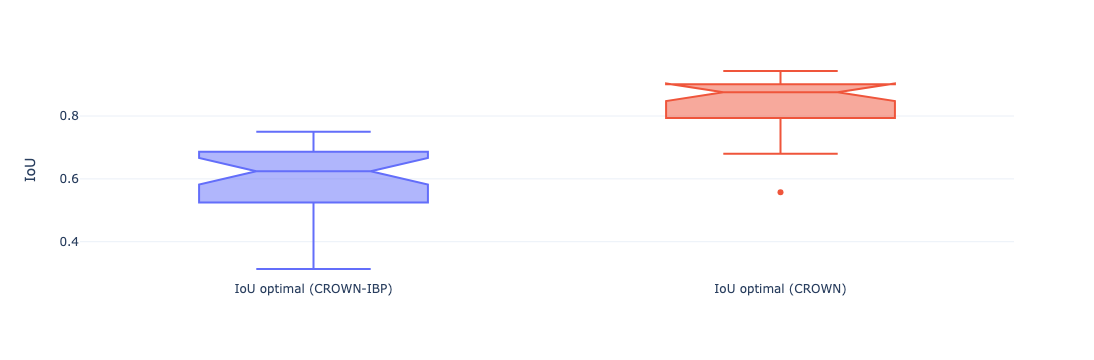

epsilon_contrast 0.04


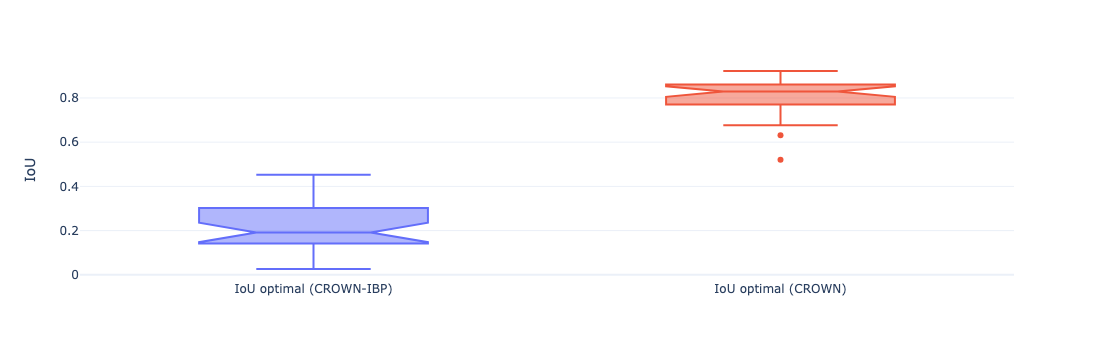

epsilon_contrast 0.06


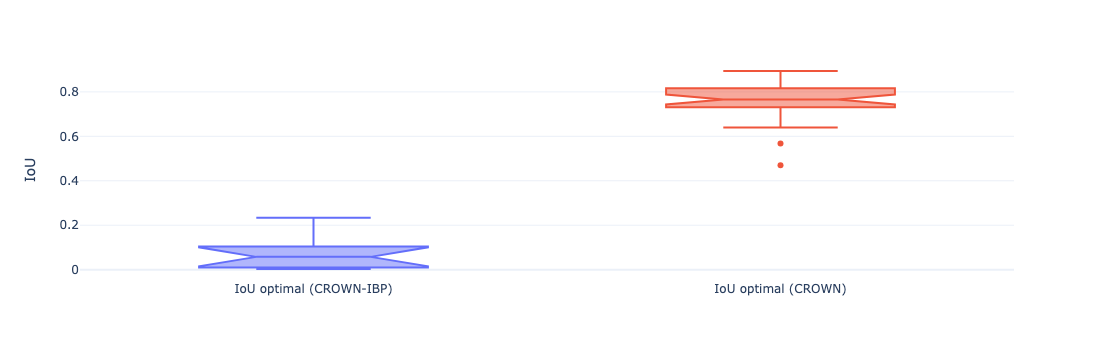

epsilon_contrast 0.08


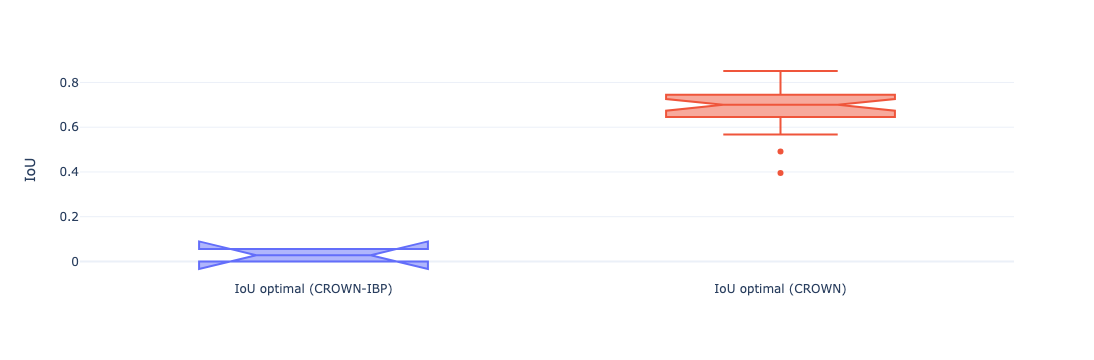

epsilon_contrast 0.1


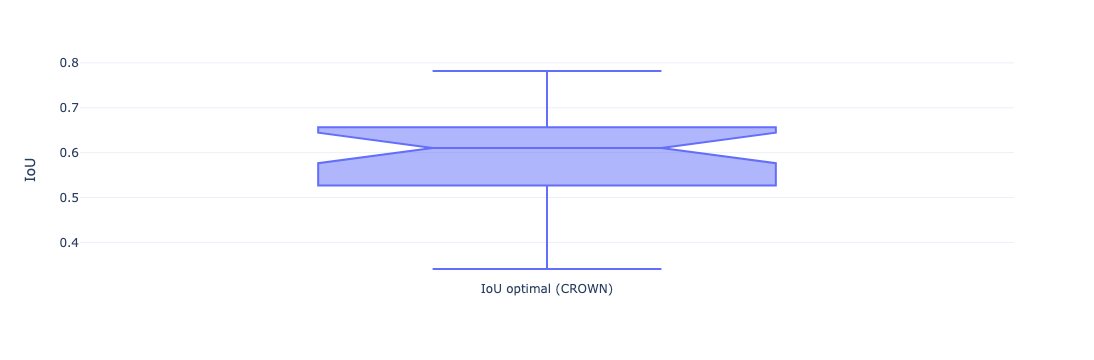

epsilon_contrast 0.12


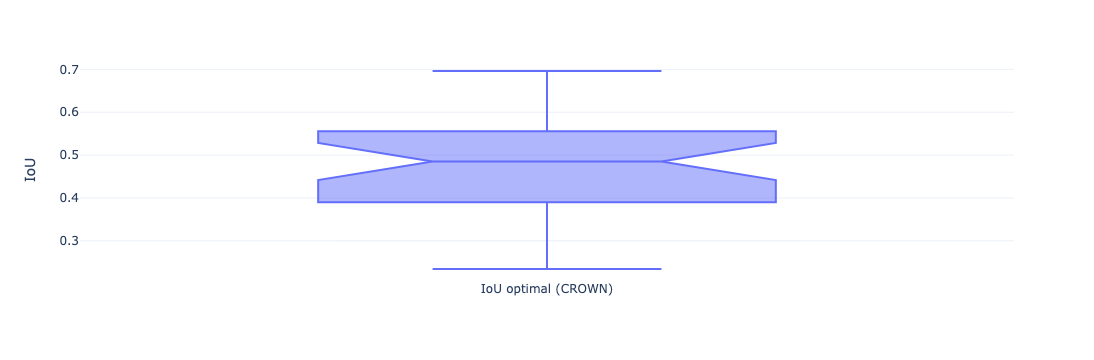

epsilon_contrast 0.14


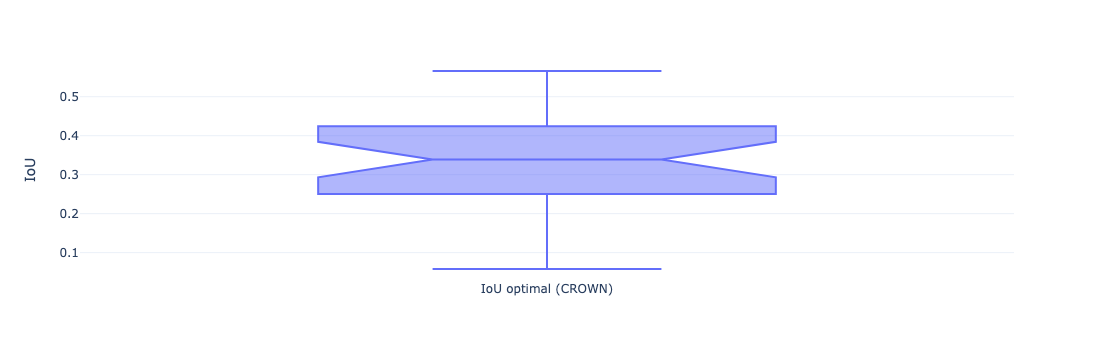

epsilon_contrast 0.16


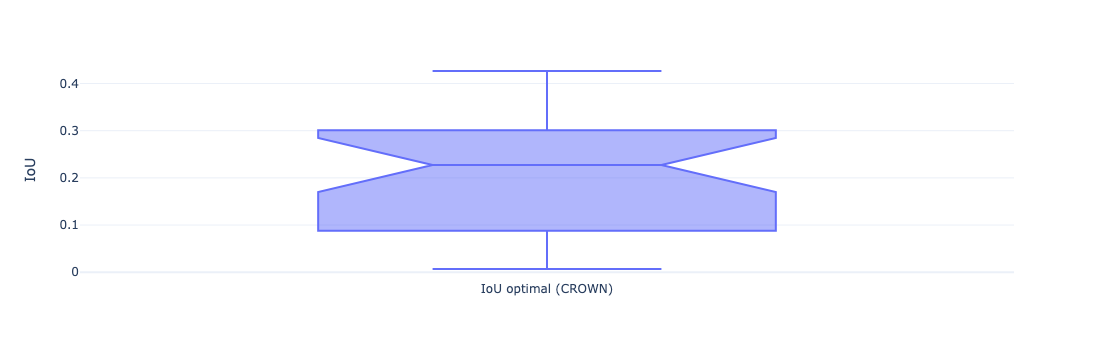

epsilon_contrast 0.18


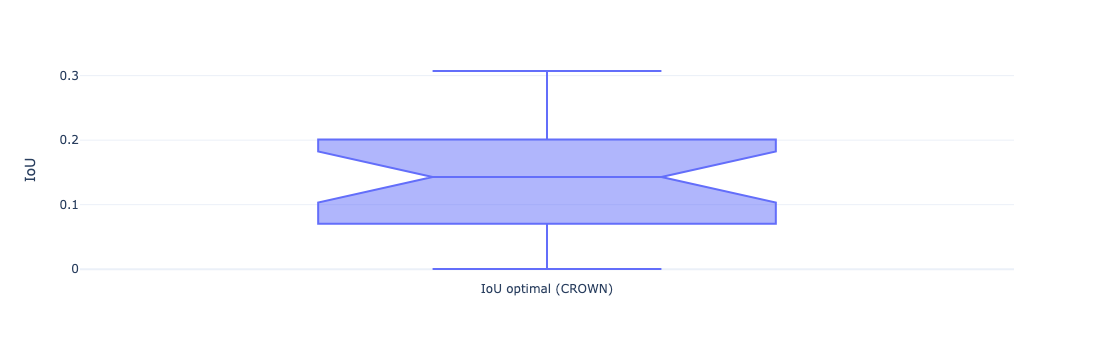

epsilon_contrast 0.2


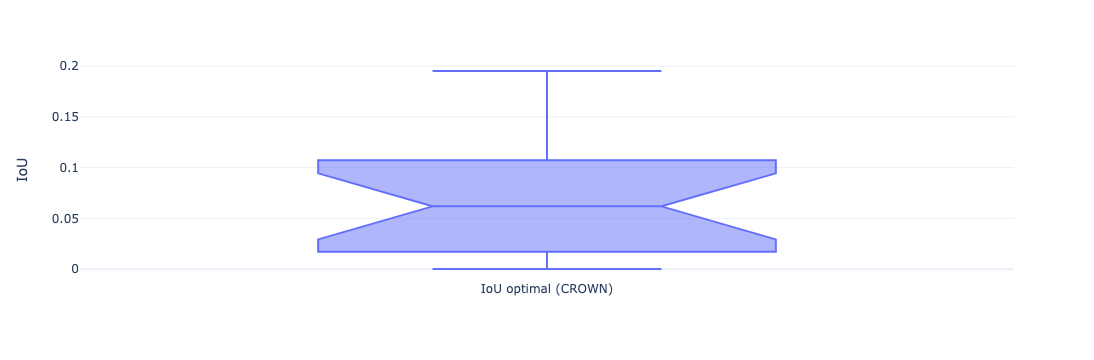

In [147]:
for eps in np.unique(combined_df["eps"]):
    print("epsilon_contrast", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==eps) & (combined_df["perturbation"]=="contrast")]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN-IBP)'}), ['IoU optimal (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN)'}), ['IoU optimal (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_lower":'IoU optimal (IBP)'}), ['IoU optimal (IBP)'], return_V=True)
    
    ious = pd.concat([df_CROWN_IBP_iou, df_CROWN_iou, df_IBP_iou])
    
    create_box_plot(ious, columns=[""], return_V=False, without_melt=True, y_axes='IoU')

In [28]:
combined_df[(combined_df["fake_iou"]==False)  & (combined_df["perturbation"]=="contrast")].describe()

Unnamed: 0     image_id  gt_logit          eps  eps_contrast  \
count  1297.000000  1297.000000    1297.0  1297.000000   1297.000000   
mean     50.353894    22.037779       0.0     0.000985      0.004923   
std      28.701402    12.674740       0.0     0.000627      0.003135   
min       2.000000     0.000000       0.0     0.000000      0.000000   
25%      26.000000    11.000000       0.0     0.000400      0.002000   
50%      50.000000    22.000000       0.0     0.001000      0.005000   
75%      74.000000    32.000000       0.0     0.001600      0.008000   
max      98.000000    43.000000       0.0     0.002000      0.010000   

       elapsed_time_perturbation  elapsed_time_eps_computed_ious  \
count                1297.000000                     1297.000000   
mean                    8.970328                        0.028494   
std                    14.566945                        0.010519   
min                     0.219252                        0.015032   
25%                     0.273536                        0.016126   
50%                     0.316571                        0.029323   
75%                    13.923433                        0.038218   
max                    52.328279                        0.053121   

       tmps_vanilla  tmps_extension      lb_box0  IoU_vanilla_delta  \
count   1297.000000     1297.000000  1297.000000        1297.000000   
mean       0.000069        0.010435    29.780022           0.271474   
std        0.000011        0.000663    18.113912           0.356371   
min        0.000059        0.009813     0.000000           0.000000   
25%        0.000062        0.010064    12.582052           0.011591   
50%        0.000065        0.010308    32.131565           0.055420   
75%        0.000073        0.010607    45.036205           0.524497   
max        0.000198        0.018857    59.434933           0.999575   

       IoU_extension_delta  Vanilla_upper  Vanilla_lower  Extension_upper  \
count         1.297000e+03    1297.000000    1297.000000      1297.000000   
mean          2.046012e-01       0.924922       0.653448         0.915044   
std           3.023541e-01       0.095058       0.317063         0.096096   
min          -2.955322e-08       0.403496       0.000425         0.403496   
25%           6.520986e-03       0.885402       0.395261         0.874633   
50%           2.950086e-02       0.942312       0.804626         0.929100   
75%           3.191761e-01       1.000000       0.885610         1.000000   
max           9.980777e-01       1.000000       0.965224         1.000000   

       Extension_lower  
count      1297.000000  
mean          0.710443  
std           0.266450  
min           0.001922  
25%           0.618691  
50%           0.833991  
75%           0.893676  
max           0.965224

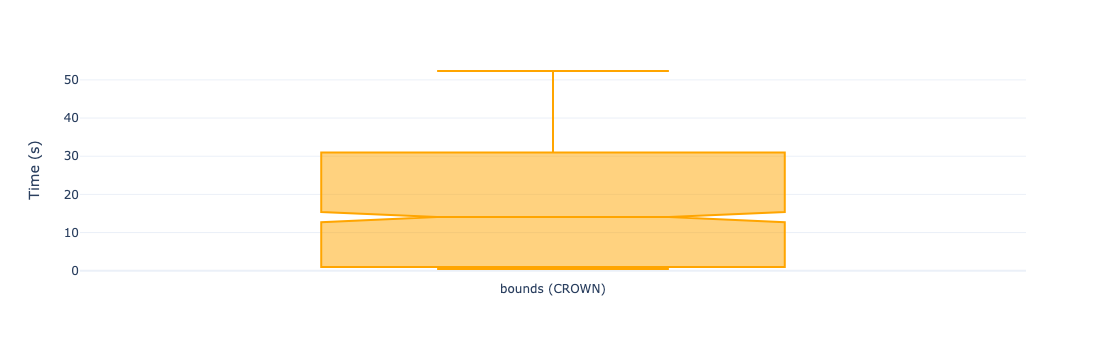

In [148]:
fig = px.box(df_CROWN, x='Time', y='Value', color='Time', 
             notched=True,  
             title='')

fig.update_layout(
    yaxis_title='Time (s)',  
    xaxis_title='',
    template='plotly_white',  
    showlegend=False  
)

fig.update_traces(marker_color='orange', line_color='orange')

## Global analysis IoU

In [149]:
list_bri_white = []
for pert in ["brightness", "whitenoise"]:
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==0.0004) & (combined_df["perturbation"]==pert)]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_lower":f'{pert} (CROWN-IBP)'}), [f'{pert} (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_lower":f'{pert} (CROWN)'}), [f'{pert} (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_lower":f'{pert} (IBP)'}), [f'{pert} (IBP)'], return_V=True)
    list_bri_white.append(df_CROWN_IBP_iou)
    list_bri_white.append(df_CROWN_iou)
    list_bri_white.append(df_IBP_iou)

epsilon 0.2
epsilon 0.2


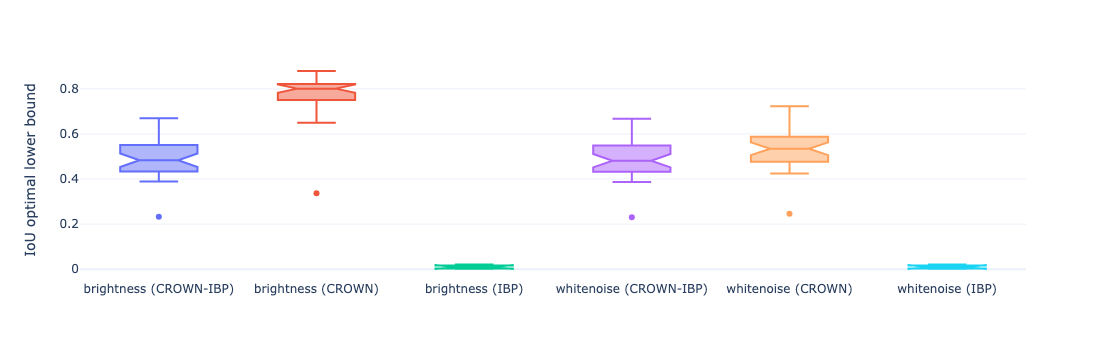

In [150]:
ious_bri_white = pd.concat(list_bri_white)

create_box_plot(ious_bri_white, columns=[""], return_V=False, without_melt=True, y_axes='IoU optimal lower bound')

epsilon 0.2
epsilon 0.2


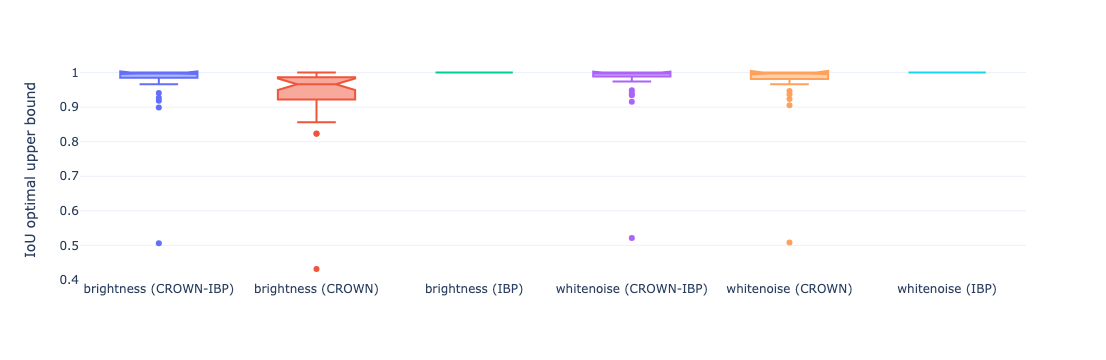

In [151]:
list_bri_white = []
for pert in ["brightness", "whitenoise"]:
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==0.0004) & (combined_df["perturbation"]==pert)]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_upper":f'{pert} (CROWN-IBP)'}), [f'{pert} (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_upper":f'{pert} (CROWN)'}), [f'{pert} (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_upper":f'{pert} (IBP)'}), [f'{pert} (IBP)'], return_V=True)
    list_bri_white.append(df_CROWN_IBP_iou)
    list_bri_white.append(df_CROWN_iou)
    list_bri_white.append(df_IBP_iou)
ious_bri_white = pd.concat(list_bri_white)
create_box_plot(ious_bri_white, columns=[""], return_V=False, without_melt=True, y_axes='IoU optimal upper bound')

epsilon 0.2
epsilon 0.2


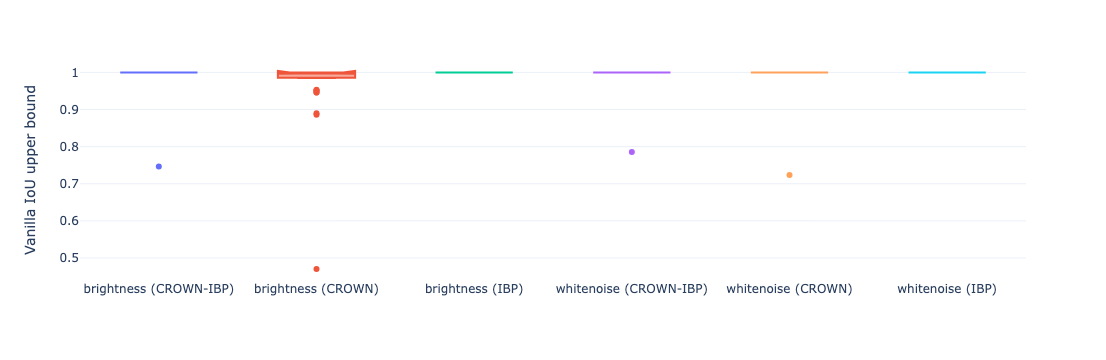

In [152]:
list_bri_white = []
for pert in ["brightness", "whitenoise"]:
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==0.0004) & (combined_df["perturbation"]==pert)]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Vanilla_upper":f'{pert} (CROWN-IBP)'}), [f'{pert} (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Vanilla_upper":f'{pert} (CROWN)'}), [f'{pert} (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Vanilla_upper":f'{pert} (IBP)'}), [f'{pert} (IBP)'], return_V=True)
    list_bri_white.append(df_CROWN_IBP_iou)
    list_bri_white.append(df_CROWN_iou)
    list_bri_white.append(df_IBP_iou)
ious_bri_white = pd.concat(list_bri_white)
create_box_plot(ious_bri_white, columns=[""], return_V=False, without_melt=True, y_axes='Vanilla IoU upper bound')

epsilon 0.2
epsilon 0.2


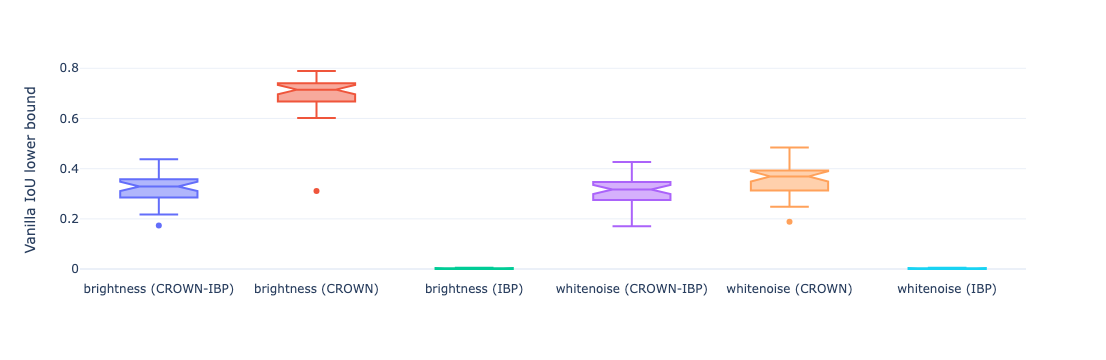

In [153]:
list_bri_white = []
for pert in ["brightness", "whitenoise"]:
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==0.0004) & (combined_df["perturbation"]==pert)]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Vanilla_lower":f'{pert} (CROWN-IBP)'}), [f'{pert} (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Vanilla_lower":f'{pert} (CROWN)'}), [f'{pert} (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Vanilla_lower":f'{pert} (IBP)'}), [f'{pert} (IBP)'], return_V=True)
    list_bri_white.append(df_CROWN_IBP_iou)
    list_bri_white.append(df_CROWN_iou)
    list_bri_white.append(df_IBP_iou)
ious_bri_white = pd.concat(list_bri_white)
create_box_plot(ious_bri_white, columns=[""], return_V=False, without_melt=True, y_axes='Vanilla IoU lower bound')

In [35]:
def optimal_up_or_down(x):
    if (x.Vanilla_lower <= 0.5) & (x.Extension_lower >= 0.5):
        return(True)
    else:
        return(False)

combined_df["optimal_up_or_down"] = combined_df.apply(lambda x: optimal_up_or_down(x), axis=1)


In [36]:
np.unique(combined_df["method"])

array(['IBP', 'IBP+backward (CROWN-IBP)', 'backward (CROWN)'],
      dtype=object)

In [37]:
nb_optimal_up_or_down = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["optimal_up_or_down"] == True) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness")  & (combined_df["fake_iou"] == False)].shape[0]
nb_optimal_up_or_down_percent_bri_CROWN = nb_optimal_up_or_down/nb_total*100
print(nb_optimal_up_or_down/nb_total*100)

22.272727272727273


In [38]:
nb_optimal_up_or_down = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["optimal_up_or_down"] == True) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise")  & (combined_df["fake_iou"] == False)].shape[0]
nb_optimal_up_or_down_percent_white_CROWN = nb_optimal_up_or_down/nb_total*100
print(nb_optimal_up_or_down/nb_total*100)

10.801393728222997


In [39]:
name1 = str(round(nb_optimal_up_or_down_percent_white_CROWN,2))+"%"

In [40]:
nb_optimal_up_or_down_percent_bri_CROWN

22.272727272727273

In [41]:
name2 = str(round(nb_optimal_up_or_down_percent_bri_CROWN,2))+"%"

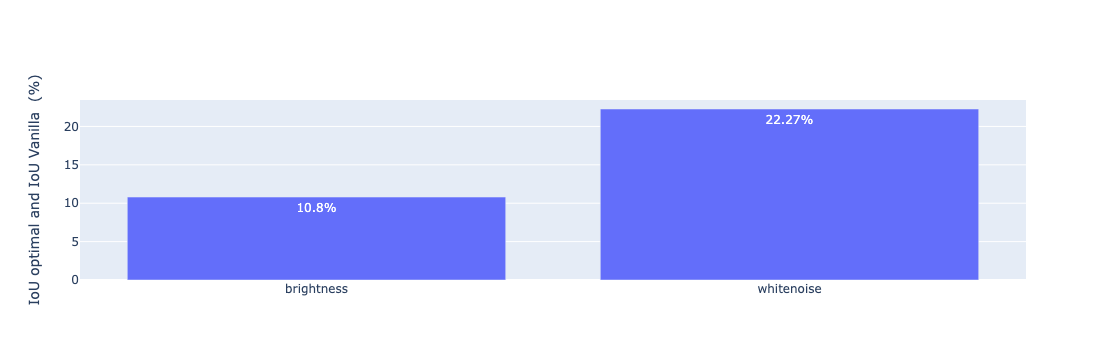

In [42]:
import plotly.graph_objects as go
perturbations=['brightness', 'whitenoise']

fig = go.Figure([go.Bar(x=perturbations, y=[nb_optimal_up_or_down_percent_white_CROWN ,nb_optimal_up_or_down_percent_bri_CROWN], text=[name1, name2])])
fig.update_yaxes(title_text="IoU optimal and IoU Vanilla  (%)")
fig.show()

In [43]:
data1 = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["Extension_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["fake_iou"] == False)].shape[0]
optimal_sup_bri_CROWN = data1/nb_total*100
print(optimal_sup_bri_CROWN)

65.0


In [44]:
data2 = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["Vanilla_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["fake_iou"] == False)].shape[0]
vanilla_sup_bri_CROWN = data2/nb_total*100
print(vanilla_sup_bri_CROWN)

42.72727272727273


In [45]:
data3 = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["Extension_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["fake_iou"] == False)].shape[0]
optimal_sup_white_CROWN = data3/nb_total*100
print(optimal_sup_white_CROWN)

37.63066202090592


In [46]:
data2 = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["Vanilla_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["fake_iou"] == False)].shape[0]
vanilla_sup_white_CROWN = data2/nb_total*100
print(vanilla_sup_white_CROWN)

26.82926829268293


In [47]:
data4 = combined_df[(combined_df["perturbation"]=="contrast") & (combined_df["Extension_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[ (combined_df["perturbation"]=="contrast") & (combined_df["fake_iou"] == False)].shape[0]
optimal_sup_contrast_CROWN = data4/nb_total*100
print(optimal_sup_contrast_CROWN)

78.7201233616037


In [48]:
data4 = combined_df[(combined_df["perturbation"]=="contrast") & (combined_df["Vanilla_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[ (combined_df["perturbation"]=="contrast") & (combined_df["fake_iou"] == False)].shape[0]
vanilla_sup_contrast_CROWN = data4/nb_total*100
print(vanilla_sup_contrast_CROWN)

72.78334618350038


# Allessio table

In [159]:
combined_df["CBA_Extension"] = combined_df["Extension_lower"].apply(lambda x: True if x >= 0.5 else False)
#bad_image  = np.unique(combined_df[(combined_df["eps"]==0) & (combined_df["CBA_Extension"] == False)]["image_id"])[0]
combined_df = combined_df[combined_df["image_id"]!= bad_image]
np.unique(combined_df[(combined_df["method"] == "backward (CROWN)") & (combined_df["CBA_Extension"] == True) & (combined_df["perturbation"] == "whitenoise")].eps)

def CBA(perturbation="whitenoise", method="backward (CROWN)", all_df=False):
    df_CBA = combined_df[(combined_df["method"] == method) & (combined_df["CBA_Extension"] == True) & (combined_df["perturbation"] == perturbation)]
    df_notCBA = combined_df[(combined_df["method"] == method) & (combined_df["perturbation"] == perturbation)]
    dff = pd.merge(df_CBA.groupby(["eps"]).agg("count")[["image_id"]].rename(columns={"image_id": "im_id_CBA"}),
               df_notCBA.groupby("eps").agg("count")[["image_id"]].rename(columns={"image_id": "im_id_notCBA"}), on="eps", how="outer")
    dff[f"%CBA_{perturbation}_{method}"] = dff.apply(lambda x: x.im_id_CBA/x.im_id_notCBA*100, axis=1)
    dff.fillna(0, inplace=True)
    if all_df == True: 
        return(dff)
    else: 
        return(list(dff[f"%CBA_{perturbation}_{method}"]))
method_pert = {}
for perturbation in np.unique(combined_df["perturbation"]):
    for method in np.unique(combined_df["method"]):
        method_pert[perturbation+"_"+method] = CBA(perturbation=perturbation, method=method)

df_Extension =  pd.DataFrame(method_pert)
df_Extension["eps"] = CBA(all_df=True).index
df_Extension.set_index(["eps"]).T.loc[["contrast_IBP", "contrast_IBP+backward (CROWN-IBP)", "contrast_backward (CROWN)"]][[0.0002, 0.001, 0.0014]]
#df.set_index(["eps"]).T.loc[["whitenoise_IBP", "whitenoise_IBP+backward (CROWN-IBP)", "whitenoise_backward (CROWN)"]][[0.0002, 0.0004, 0.0006]]

eps                                    0.0002     0.0010    0.0014
contrast_IBP                         0.000000   0.000000  0.000000
contrast_IBP+backward (CROWN-IBP)   82.857143   0.000000  0.000000
contrast_backward (CROWN)          100.000000  88.571429  8.571429

In [162]:
df_Extension.set_index(["eps"]).T.loc[["contrast_IBP", "contrast_IBP+backward (CROWN-IBP)", "contrast_backward (CROWN)"]][[0.0002, 0.001, 0.0014]]

eps                                    0.0002     0.0010    0.0014
contrast_IBP                         0.000000   0.000000  0.000000
contrast_IBP+backward (CROWN-IBP)   82.857143   0.000000  0.000000
contrast_backward (CROWN)          100.000000  88.571429  8.571429

In [163]:
2*(10**(-4)) 

0.0002

In [158]:
combined_df["CBA_Vanilla"] = combined_df["Vanilla_lower"].apply(lambda x: True if x >= 0.5 else False)
#bad_image  = np.unique(combined_df[(combined_df["eps"]==0) & (combined_df["CBA"] == False)]["image_id"])[0]
combined_df = combined_df[combined_df["image_id"]!= bad_image]
np.unique(combined_df[(combined_df["method"] == "backward (CROWN)") & (combined_df["CBA_Vanilla"] == True) & (combined_df["perturbation"] == "whitenoise")].eps)

def CBA(perturbation="whitenoise", method="backward (CROWN)", all_df=False):
    df_CBA = combined_df[(combined_df["method"] == method) & (combined_df["CBA_Vanilla"] == True) & (combined_df["perturbation"] == perturbation)]
    df_notCBA = combined_df[(combined_df["method"] == method) & (combined_df["perturbation"] == perturbation)]
    dff = pd.merge(df_CBA.groupby(["eps"]).agg("count")[["image_id"]].rename(columns={"image_id": "im_id_CBA"}),
               df_notCBA.groupby("eps").agg("count")[["image_id"]].rename(columns={"image_id": "im_id_notCBA"}), on="eps", how="outer")
    dff[f"%CBA_{perturbation}_{method}"] = dff.apply(lambda x: x.im_id_CBA/x.im_id_notCBA*100, axis=1)
    dff.fillna(0, inplace=True)
    if all_df == True: 
        return(dff)
    else: 
        return(list(dff[f"%CBA_{perturbation}_{method}"]))
method_pert = {}
for perturbation in np.unique(combined_df["perturbation"]):
    for method in np.unique(combined_df["method"]):
        method_pert[perturbation+"_"+method] = CBA(perturbation=perturbation, method=method)

df_Vanilla =  pd.DataFrame(method_pert)
df_Vanilla["eps"] = CBA(all_df=True).index
df_Vanilla.set_index(["eps"]).T.loc[["whitenoise_IBP", "whitenoise_IBP+backward (CROWN-IBP)", "whitenoise_backward (CROWN)"]][[0.0002, 0.0004, 0.0006]]

eps                                     0.0002  0.0004  0.0006
whitenoise_IBP                        0.000000     0.0     0.0
whitenoise_IBP+backward (CROWN-IBP)  75.675676     0.0     0.0
whitenoise_backward (CROWN)          97.297297     0.0     0.0

In [160]:
df_Vanilla.set_index(["eps"]).T.loc[["contrast_IBP", "contrast_IBP+backward (CROWN-IBP)", "contrast_backward (CROWN)"]][[0.0002, 0.001, 0.0014]]


eps                                    0.0002    0.0010  0.0014
contrast_IBP                         0.000000  0.000000     0.0
contrast_IBP+backward (CROWN-IBP)   31.428571  0.000000     0.0
contrast_backward (CROWN)          100.000000  8.571429     0.0

In [ ]:
)

In [ ]:
dff